# Coursework final

- Andy Yuan
- Aidan Dignam
- Amelia Walker
- Owen Stevenson


# Question 1

In [ ]:
# Imports

import numpy as np
import polars as pl
import pandas as pd

# Clustering
from sklearn.cluster import AgglomerativeClustering, KMeans, SpectralClustering, MiniBatchKMeans

# Dimensionality reduction
from sklearn.decomposition import PCA, SparsePCA, TruncatedSVD
from sklearn.manifold import TSNE

# Tree-based models
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, export_graphviz
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, BaggingRegressor, RandomForestRegressor

# Model selection and evaluation
from sklearn.model_selection import (
    GridSearchCV, train_test_split, StratifiedKFold, cross_val_score,
    cross_validate, RepeatedKFold, KFold, RandomizedSearchCV
)

from sklearn.metrics import (
    silhouette_samples, silhouette_score, confusion_matrix,
    roc_curve, roc_auc_score, classification_report, accuracy_score, r2_score, mean_squared_error
)
from sklearn.utils import resample

# Preprocessing and feature selection
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SequentialFeatureSelector

# Linear models
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV, ElasticNet, ElasticNetCV
from sklearn import linear_model

# XGBoost
from xgboost import XGBRegressor, XGBClassifier
import xgboost as xgb

# Shap
import shap
shap.initjs() # Import Java engine.

# Plotting
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

# Statistical and optimization tools
from scipy.sparse import csr_matrix
from scipy.stats import zscore
from scipy.special import factorial
import scipy.optimize as so

# Text processing
import sklearn.feature_extraction.text as sktext
import re

# Dimensionality reduction
import umap.umap_ as umap

# Miscellaneous
import os
from itertools import chain, combinations
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from yellowbrick.cluster.elbow import kelbow_visualizer
import heapq
from joblib import Parallel, delayed

In [ ]:
householdspend = pl.read_csv("../Coursework Data/HouseholdSpend.csv")
demographics = pl.read_csv("../Coursework Data/DemoStats.csv")

In [ ]:
# Combine data on the CODE variable
data_combined = householdspend.join(demographics, on="CODE", how="full")

# Must split into train and test before doing any replacement,
train_data, test_data = train_test_split(data_combined, train_size=0.7, random_state = 2025)

In [ ]:
# Dropping columns that were created from the merge
columns_to_drop = ["CODE", "CODE_right", "GEO", "GEO_right"]
ifexisting_cols = [col for col in columns_to_drop if col in data_combined.columns]
# Apply to train and test data
train_data = train_data.drop(ifexisting_cols)
test_data = test_data.drop(ifexisting_cols)

In [ ]:
# removing columns for clustering
response_columns = ["HSHNIAGG", "HSAGDISPIN", "HSAGDISCIN", # spending variables
                    "HSEP001", "HSEP002", "HSEP003", "HSEP004", "HSEP005", "HSEP006", "HSEP007",  # pension variables
                    "HSTT001", "HSTE001", "HSTX001", "HSTC001", "HSSH001S", "HSFD001S","HSHO001S", # summary variables
                    "HSHC001S", "HSHF001S", "HSTR001S", "HSRE001S", "HSPC001S", "HSCL001S", "HSED002S",
                    "HSRO001S", "HSTA001S", "HSGC001S", "HSME001S", "HSEP001S", "HSMG001S", "HSTE001ZBS",
                    "HSWH002S", "HSWH028S", "HSWH040S", "HSWH041S", "HSWH042S",
                    "ECYHRI_020", "ECYHRI2040", "ECYHRI4060", "ECYHRI6080", "ECYHRIX100", "ECYHRI100P", # demo stats on income
                    "ECYHRIX125", "ECYHRIX150", "ECYHRIX200", "ECYHRI200P", "ECYHRIX300", "ECYHRI300P",
                    "ECYHRIAVG", "ECYHRIMED", "ECYHRIAGG", "ECYHNI_020", "ECYHNI2040", "ECYHNI4060",
                    "ECYHNI6080", "ECYHNIX100", "ECYHNI100P", "ECYHNIX125", "ECYHNIX150", "ECYHNIX200", "ECYHNI200P",
                    "ECYHNIX300", "ECYHNI300P", "ECYHNIAVG", "ECYHNIMED", "ECYHNIAGG", "ECYPNIAVG","ECYPNIHP15",
                    "HSSH006", "HSSH019", "HSSH015", "HSSH044", "HSHC022", "HSHC023", "HSHC024", "HSHC025", "HSTR032" # spending variables
]
ifexisting_response_cols = [col for col in response_columns if col in data_combined.columns]

# Apply to test and train data, create new variable to cluster
clustering_train = train_data.drop(ifexisting_response_cols)
clustering_test = test_data.drop(ifexisting_response_cols)
# Done so we can use the train_data and test_data later in regression

In [ ]:
# identify which columns are strings
string_columns = train_data.select(pl.col(pl.Utf8())).columns

# Replace NA with median values of the columns converted to string, using train data median values
for col in string_columns:
    median = ( # median of train data
        train_data[col].replace("NA", None)
        .cast(pl.Float64)
        .median()
    )
    train_data = train_data.with_columns( # will be used for regression
        pl.col(col).replace("NA", None)
        .cast(pl.Float64)
        .fill_null(median)
        .alias(col)
    )
    clustering_train = clustering_train.with_columns( # for clustering only
        pl.col(col).replace("NA", None)
        .cast(pl.Float64)
        .fill_null(median)
    )
    test_data = test_data.with_columns( # will be used for regression
        pl.col(col).replace("NA", None)
        .cast(pl.Float64)
        .fill_null(median) # fill with median of train data
    )
    clustering_test = clustering_test.with_columns( # for clustering only
        pl.col(col).replace("NA", None)
        .cast(pl.Float64)
        .fill_null(median) # fill with median of train data
    )

In [ ]:
# Taking a look at the data, with response columns
train_data.describe()

statistic,HSBASHHD,HSHNIAGG,HSAGDISPIN,HSAGDISCIN,HSTT001,HSTE001,HSTX001,HSTC001,HSSH001S,HSFD001S,HSHO001S,HSHC001S,HSHF001S,HSTR001S,HSRE001S,HSPC001S,HSCL001S,HSED002S,HSRO001S,HSTA001S,HSGC001S,HSME001S,HSEP001S,HSMG001S,HSTE001ZBS,HSWH002S,HSWH028S,HSWH040S,HSWH041S,HSWH042S,HSSH001,HSSH002,HSSH003,HSSH004,HSSH053,HSSH054,…,ECYRIMINDI,ECYRIMNEPA,ECYRIMPAKI,ECYRIMSRI,ECYRIMSASO,ECYRIMOCE,ECYRIMAUSS,ECYRIMOCEO,ECYPIMHPOP,ECYPIMNI,ECYPIMIM,ECYPIMP01,ECYPIM0110,ECYPIM1115,ECYPIM1621,ECYPIM22CY,ECYPIMNPER,ECYAIMHPOP,ECYAIMNI,ECYAIMIM,ECYAIM_0_5,ECYAIM_514,ECYAIM1524,ECYAIM2544,ECYAIM45P,ECYAIMNPER,ECYGENHPOP,ECYGEN1GEN,ECYGEN2GEN,ECYGEN3GEN,ECYTCAHPOP,ECYTCACIT,ECYTCA_U18,ECYTCA_18P,ECYNCANCIT,ECYNCA_U18,ECYNCA_18P
str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""count""",608279.0,608279.0,608279.0,608279.0,608279.0,608279.0,608279.0,608279.0,608279.0,608279.0,608279.0,608279.0,608279.0,608279.0,608279.0,608279.0,608279.0,608279.0,608279.0,608279.0,608279.0,608279.0,608279.0,608279.0,608279.0,608279.0,608279.0,608279.0,608279.0,608279.0,608279.0,608279.0,608279.0,608279.0,608279.0,608279.0,…,608279.0,608279.0,608279.0,608279.0,608279.0,608279.0,608279.0,608279.0,608279.0,608279.0,608279.0,608279.0,608279.0,608279.0,608279.0,608279.0,608279.0,608279.0,608279.0,608279.0,608279.0,608279.0,608279.0,608279.0,608279.0,608279.0,608279.0,608279.0,608279.0,608279.0,608279.0,608279.0,608279.0,608279.0,608279.0,608279.0,608279.0
"""null_count""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,…,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""mean""",18.505115,2.2626e6,1.7238e6,1.2392e6,2.4116e6,2.2009e6,423209.823681,1.6131e6,390207.179942,279255.161129,111887.37018,109876.727277,76415.761653,272453.143834,88293.198336,45491.797261,71054.161279,34485.648004,3588.37441,70743.670012,25943.550577,33441.056207,115633.350406,48956.401378,210629.749926,67992.441264,4823.41001,113608.694673,15133.147703,9072.056276,390207.179942,304787.019089,89380.861689,88180.613863,87567.023167,613.590696,…,0.475481,0.005647,0.038527,0.008743,0.000294,0.007242,0.005139,0.002103,46.035674,31.880372,11.747136,4.725555,2.363264,1.391048,1.632757,1.634511,2.408166,46.035674,31.880372,11.747136,1.065733,2.036413,2.229684,5.291205,1.124101,2.408166,46.035674,14.158953,7.460665,24.416056,46.035674,40.689125,7.785901,32.903224,5.34655,0.854351,4.492198
"""std""",70.886858,8.4449e6,6.4618e6,4.7287e6,9.3466e6,8.2262e6,1.6205e6,6.0583e6,1.3965e6,1.0718e6,430183.638559,439069.769635,296558.361743,1.1009e6,333775.377327,167739.493808,252953.878919,116835.006737,14768.113483,268292.706488,97612.564862,130138.646141,439481.741856,211961.009232,1.3148e6,351657.299377,40380.835359,927454.989631,52136.466083,36694.039599,1.3965e6,1.0508e6,292767.24044,288406.910856,286399.843871,2381.414019,…,2.486168,0.125415,0.353543,0.139325,0.021105,0.117661,0.095502,0.055302,175.157275,152.949196,32.650807,14.38387,7.179114,4.583791,5.747218,5.720639,10.499825,175.157275,152.949196,32.650807,3.394052,6.080894,6.507734,14.823808,3.896334,10.499825,175.157275,39.981126,25.023536,134.439204,175.157275,167.258769,35.236248,133.355852,17.88653,3.168746,15.052397
"""min""",0.0,0.0,0.0,0.0,-24249.492537,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.4599e7,0.0,0.0,-1.6806e7,-26676.98553,-116332.638685,0.0,0.0,0.0,0.0,0.0,0.0,…,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""25%""",3.0,267155.787608,214057.554764,150195

## a. Data clean


In [ ]:
# Scale data
scaler = StandardScaler()
clustering_train_scaled = pd.DataFrame(scaler.fit_transform(clustering_train.to_pandas()), columns=clustering_train.columns)
clustering_test_scaled = pd.DataFrame(scaler.transform(clustering_test.to_pandas()), columns=clustering_test.columns)

## b. K-means

### Clusterer and elbow

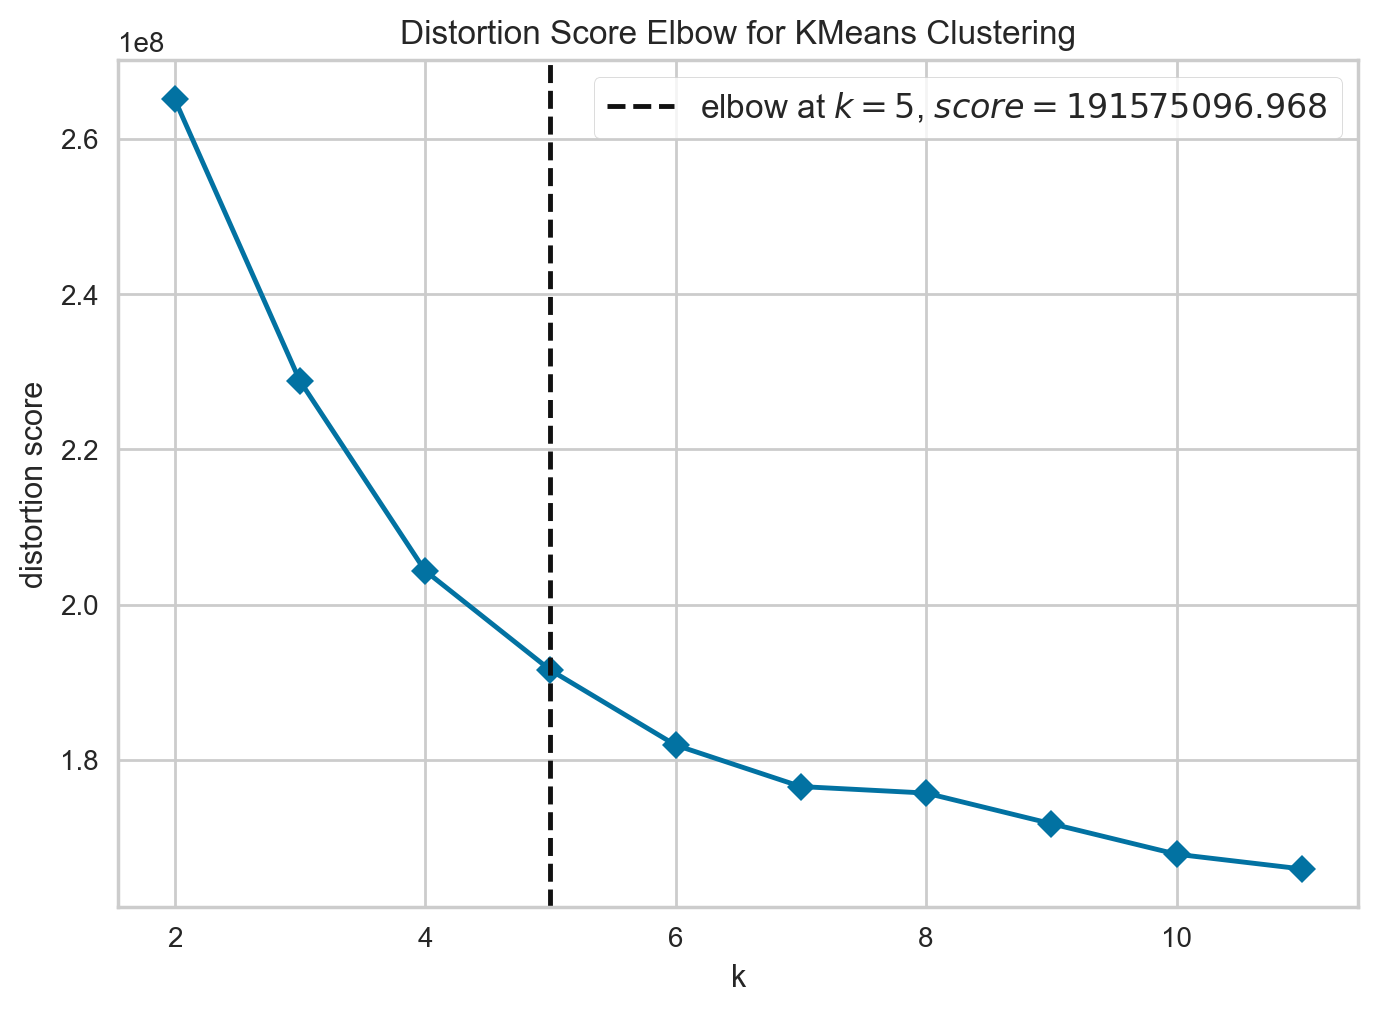

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [ ]:
clustering_train_scaled_sample = clustering_train_scaled.sample(n=400000, random_state=2025) # sample for size of data set

# k-means clusterer created to use for visualizer
KClusterer = KMeans(n_clusters=3, # initialized with 3 for simplicity
                   verbose=0,
                   random_state=2025)

# Elbow visualizer
visualizer = KElbowVisualizer(KClusterer,
                              k=(2,12), # from 2 to 11 clusters
                              locate_elbow=True,
                              timings=False)
# Fit to scaled data sample
visualizer.fit(clustering_train_scaled_sample)
visualizer.show()
## Chosen: 5 clusters

### Silhouette

In [ ]:
# Silhouette scorer
sil_scores = {}

for i in range(2,8):

    sample_scores = []

    for j in range(10):
        current_sample = clustering_train_scaled.sample(n=10000, replace=False, random_state=j)

        Kmeansclusterer = KMeans(n_clusters=i,
                                verbose=0,
                                random_state=2025)
        cluster_labels_silhouette = Kmeansclusterer.fit_predict(current_sample.values)
        sil_avg = silhouette_score(current_sample.values, cluster_labels_silhouette, metric = "cosine", n_jobs = -1)
        sample_scores.append(sil_avg)

    sil_scores[f'{i} clusters'] = np.mean(sample_scores)

print("Silhouette Scores:", sil_scores)
max_values = heapq.nlargest(3, sil_scores.values())
max_keys = [key for key, value in sil_scores.items() if value in max_values]
print("The greatest silhouette scores are from ", max_keys, "with scores of", max_values)

# Chosen: 2 clusters, decreases from there
# Run time: 5 minutes for 10 iterations of 10,000 samples each

Silhouette Scores: {'2 clusters': np.float64(0.21607827392998763), '3 clusters': np.float64(0.1980893805458491), '4 clusters': np.float64(0.19252133128221496), '5 clusters': np.float64(0.1975880441639845), '6 clusters': np.float64(0.16274183362341793), '7 clusters': np.float64(0.16930163623079558)}
The greatest silhouette scores are from  ['2 clusters', '3 clusters', '5 clusters'] with scores of [np.float64(0.21607827392998763), np.float64(0.1980893805458491), np.float64(0.1975880441639845)]


### Applying k-means according to best cluster number

In [ ]:
# optimal kmeans function according to k-elbow and/or silhouette
KClusterer = KMeans(n_clusters=2, # put in optimal cluster amount
                   verbose=0,
                   random_state=2025)
# fitting to the training data (scaled)
KClusterer.fit(clustering_train_scaled)
# cluster means in unscaled units
unscaled_centroids = scaler.inverse_transform(KClusterer.cluster_centers_)
centroids_df = pd.DataFrame(unscaled_centroids, columns=clustering_train.columns)
print("Cluster Centroids (Original Units):\n", centroids_df)

# cluster assignments
train_cluster_labels = KClusterer.predict(clustering_train_scaled)
test_cluster_labels = KClusterer.predict(clustering_test_scaled)

# Create data_cluster_table for feature analysis
data_cluster_table = clustering_train.with_columns(
    pl.Series("cluster_label", train_cluster_labels)
)

Cluster Centroids (Original Units):
       HSBASHHD       HSSH001       HSSH002       HSSH003       HSSH004  \
0    16.812815  3.588475e+05  2.816233e+05  8.495829e+04  8.383535e+04   
1  1598.058372  2.966063e+07  2.192529e+07  4.217308e+06  4.143950e+06   

        HSSH053       HSSH054       HSSH005      HSSH007       HSSH010  ...  \
0  8.324501e+04    590.335863    165.229973   181.766823  1.687706e+05  ...   
1  4.121631e+06  22319.101926  17999.299955  3863.930960  1.451910e+07  ...   

   ECYGEN1GEN  ECYGEN2GEN   ECYGEN3GEN   ECYTCAHPOP    ECYTCACIT  ECYTCA_U18  \
0   13.753660    7.001435    21.028855    41.783950    36.558528    6.946403   
1  392.450077  436.095238  3185.949309  4014.494624  3896.090630  791.353303   

    ECYTCA_18P  ECYNCANCIT  ECYNCA_U18  ECYNCA_18P  
0    29.612125    5.225422    0.835225    4.390198  
1  3104.737327  118.403994   18.706605   99.697389  

[2 rows x 908 columns]


## c. Linear dimensionality reductions

### i. Applying PCA

In [ ]:
## PCA
nPCA = PCA(n_components=10)
nPCA.fit(np.asarray(clustering_train_scaled))
total_variance = np.sum(nPCA.explained_variance_ratio_) * 100
print('The total explained variance of the first %i components is %.3f percent' % (nPCA.n_components_, total_variance))

The total explained variance of the first 10 components is 68.532 percent


### ii. Plot the data of the first two PCs in a scatterplot (scaled data)

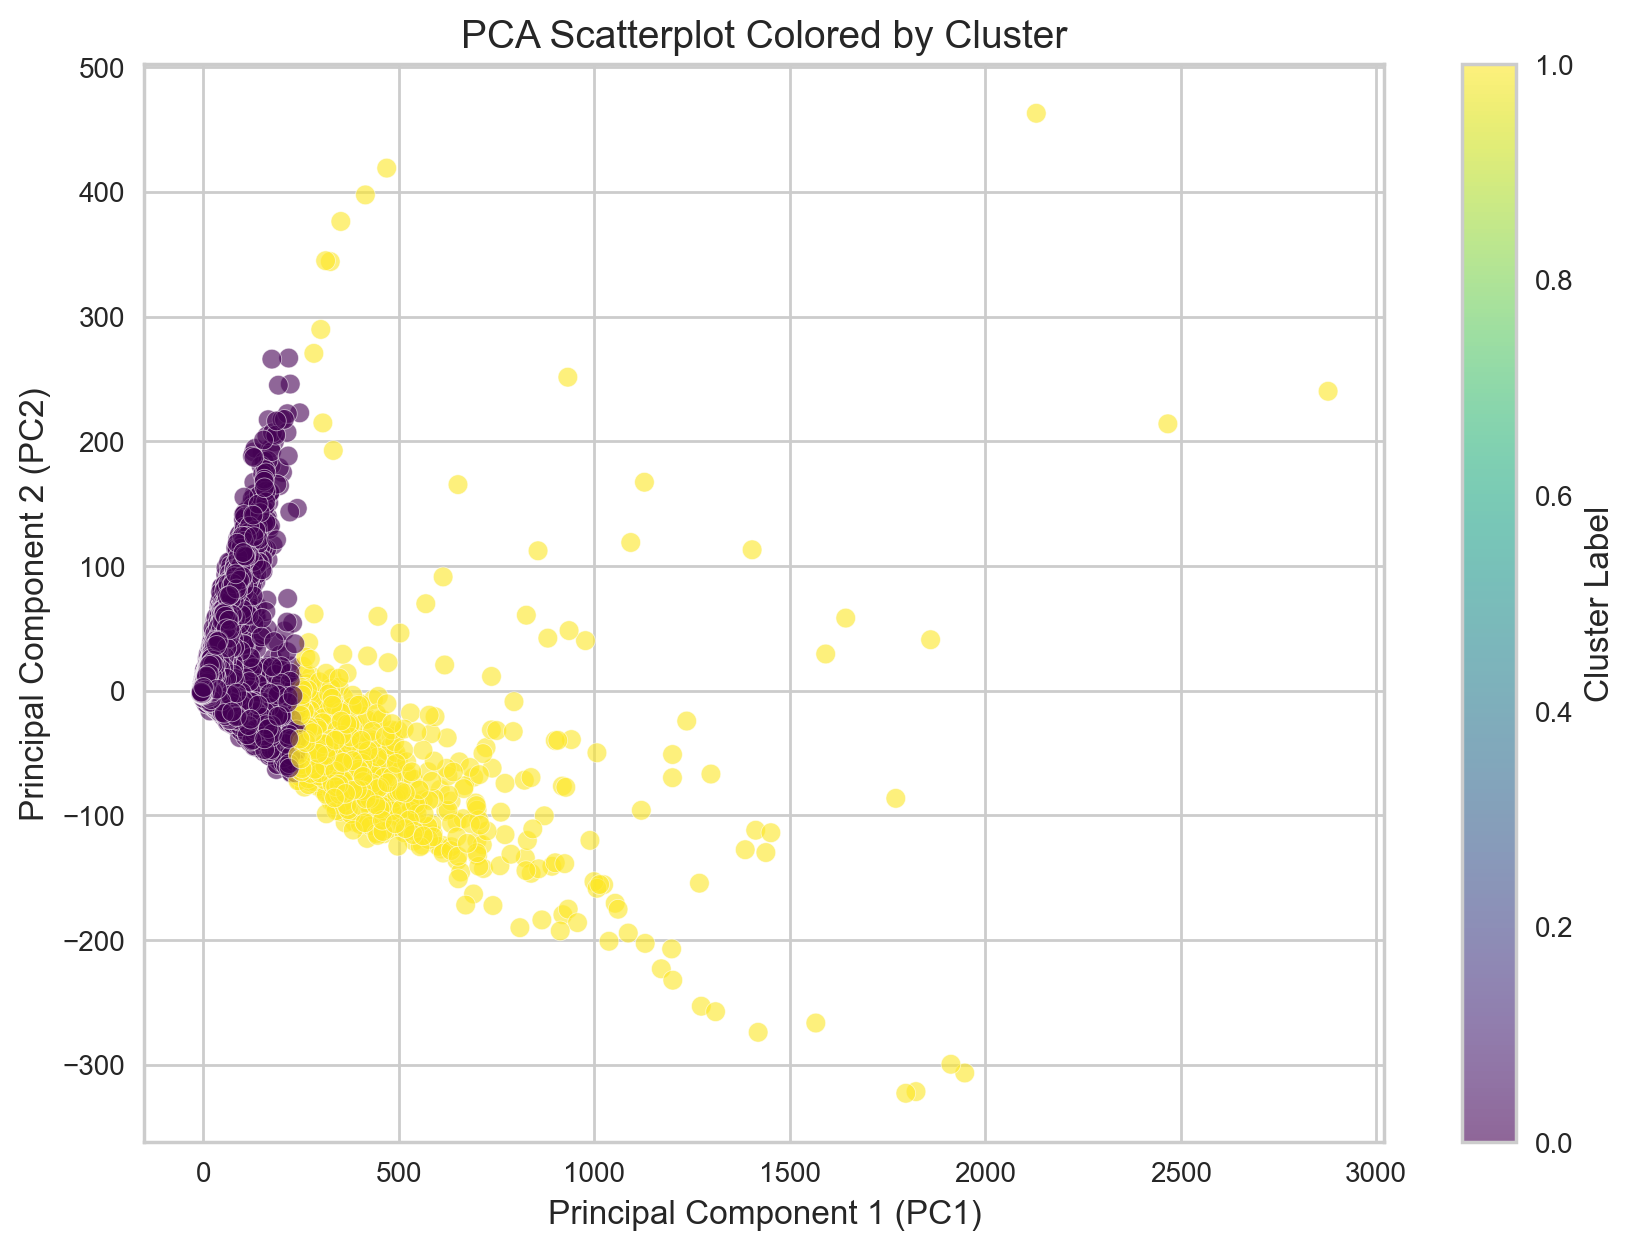

In [ ]:
# Plot the data of the first two PCs in a scatterplot (scaled data)
pca_components = nPCA.transform(np.asarray(clustering_train_scaled))
pc1 = pca_components[:, 0]  # First principal component
pc2 = pca_components[:, 1]  # Second principal component
pc3 = pca_components[:, 2]  # Third principal component

plt.figure(figsize=(10, 7))
scatter = plt.scatter(
    pc1,
    pc2,
    c=train_cluster_labels,
    cmap='viridis',  # You can change to 'plasma', 'rainbow', etc.
    alpha=0.6,       # Slightly transparent points
    edgecolors='w',  # White edges for better visibility
    s=50            # Point size
)

plt.xlabel('Principal Component 1 (PC1)', fontsize=12)
plt.ylabel('Principal Component 2 (PC2)', fontsize=12)
plt.title('PCA Scatterplot Colored by Cluster', fontsize=14)

cbar = plt.colorbar(scatter)
cbar.set_label('Cluster Label', fontsize=12)

plt.show()

### iii. Calculate average value of first three components, put into table

In [ ]:
# Calculate average value of first three components, put into table
pca_df = pd.DataFrame({
    'PC1': pc1,
    'PC2': pc2,
    'PC3': pc3,
    'Cluster': train_cluster_labels # from KClusterer.fit(clustering_train_scaled)
})

# 1. Get PCA loadings (feature contributions)
loadings = pd.DataFrame(
    nPCA.components_.T[:, :3],
    columns=['PC1', 'PC2', 'PC3'],
    index=clustering_train.columns
)

pca_cluster_means = pca_df.groupby('Cluster').mean().reset_index()
feature_means = data_cluster_table.group_by("cluster_label").mean()

def name_cluster(row):
    # Find dominant PC
    pc_scores = {'PC1': row['PC1'], 'PC2': row['PC2'], 'PC3': row['PC3']}
    dominant_pc = max(pc_scores.keys(), key=lambda k: abs(pc_scores[k]))

    # Get top 3 features for this PC
    top_features = loadings[dominant_pc].abs().nlargest(3).index.tolist()

    # Describe feature trends
    trends = []
    for feat in top_features:
        feat_mean = feature_means.select(pl.col(feat)).mean().item()
        cluster_feat_val = feature_means.filter(pl.col("cluster_label") == row['Cluster']).select(feat).item()
        trend = "High" if cluster_feat_val > feat_mean else "Low"
        trends.append(f"{trend} {feat}")

    direction = "High" if pc_scores[dominant_pc] > 0 else "Low"
    return f"{direction} {dominant_pc} ({', '.join(trends)})"

# Apply naming and merge results
pca_cluster_means['Cluster_Name'] = pca_cluster_means.apply(name_cluster, axis=1)
final_results = pca_cluster_means.merge(
    feature_means.to_pandas(),
    left_on='Cluster',
    right_on='cluster_label'
)

print("PCA Component Averages with Cluster Interpretation:")
print(pca_cluster_means[['Cluster', 'Cluster_Name', 'PC1', 'PC2', 'PC3']])

print("\nDetailed Feature Means per Cluster:")
display(feature_means.to_pandas().style.background_gradient(cmap='Blues'))

PCA Component Averages with Cluster Interpretation:
   Cluster                                       Cluster_Name         PC1  \
0        0  Low PC1 (Low ECYBAS12HP, Low ECYMARHP15, Low E...   -0.517887   
1        1  High PC1 (High ECYBAS12HP, High ECYMARHP15, Hi...  483.383436   

         PC2       PC3  
0   0.060959 -0.000039  
1 -56.897813  0.036367  

Detailed Feature Means per Cluster:


## d. UMAP

### Choice of parameters

In [ ]:
# best parameters to use: {'n_neighbors': 5, 'min_dist': 0.1, 'metric': 'euclidean'}
# run time: 10 minutes on 10000 rows
# Define parameter grid
param_grid = {
    'n_neighbors': [5, 15, 30, 50],
    'min_dist': [0.01, 0.1, 0.5],
    'metric': ['euclidean', 'cosine']
}

KClusterer = KMeans(n_clusters=2, # put in optimal cluster amount
                   verbose=0,
                   random_state=2025)
# fitting to the training data (scaled)
KClusterer.fit(clustering_train_scaled)

clustering_train_scaled_sample = clustering_train_scaled.sample(n=10000, random_state=2025)
jittered_clustering = clustering_train_scaled_sample + np.random.normal(0, 1e-5, clustering_train_scaled_sample.shape)
train_labels_umap = KClusterer.predict(jittered_clustering)

reducer = umap.UMAP(random_state=2025, n_jobs=1, verbose=0)

randomized_search = RandomizedSearchCV(
    reducer,
    param_grid,
    n_iter=10,
    scoring=silhouette_score,  # Use silhouette score as the evaluation metric
    cv=3,                      # Perform 3-fold cross-validation
    random_state=2025,
    n_jobs=-1,
    verbose=0
)

# Fit RandomizedSearchCV
randomized_search.fit(jittered_clustering, train_labels_umap)

# Get the best parameters and score
best_params = randomized_search.best_params_
best_score = randomized_search.best_score_

print(f"Best parameters: {best_params}, Silhouette score: {best_score:.3f}")

c:\Users\Andy Yuan\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(
c:\Users\Andy Yuan\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Andy Yuan\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Best parameters: {'n_neighbors': 30, 'min_dist': 0.01, 'metric': 'euclidean'}, Silhouette score: nan


### Plot UMAP

c:\Users\Andy Yuan\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


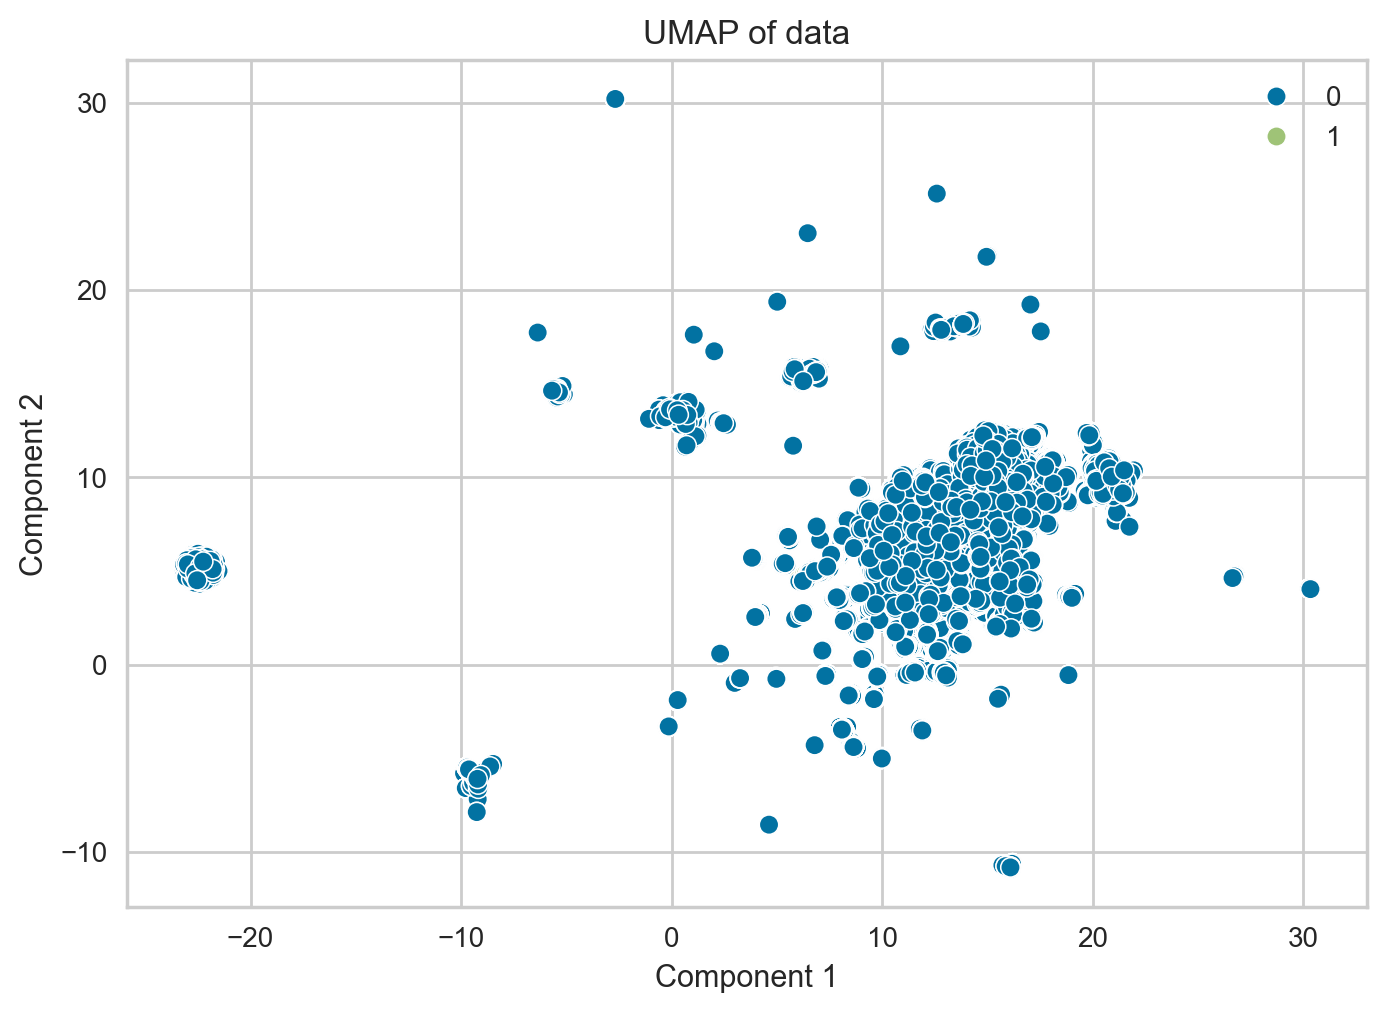

In [ ]:
best_neighbours = randomized_search.best_params_["n_neighbors"]
best_dist = randomized_search.best_params_["min_dist"]
best_metric = randomized_search.best_params_["metric"]
clustering_train_scaled_sample = clustering_train_scaled.sample(n=400000, random_state=2025) # sample for size of data set

reducer = umap.UMAP(n_neighbors=best_neighbours,              # Number of neareast neighbours to use. (set to best)
                    n_components=2,              # Number of components. UMAP is robust to larger values
                    metric=best_metric,             # Metric to use. (set to best)
                    n_epochs=1000,               # Iterations. Set to convergence. None implies either 200 or 500.
                    min_dist=best_dist,                # Minimum distance embedded points. Smaller makes clumps, larger, sparseness. (set to best)
                    spread=1.0,                  # Scale to combine with min_dist
                    low_memory=False,             # Run slower, but with less memory.
                    n_jobs=-1,                   # Cores to use
                    verbose=0                 # Verbosity
                   )

umap_labels = KClusterer.predict(clustering_train_scaled)
UMAP_embedding = reducer.fit_transform(clustering_train_scaled)

sns.scatterplot(x=UMAP_embedding[:, 0], y=UMAP_embedding[:, 1], hue=umap_labels)
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.title("UMAP of data")
plt.show()

# Question 2


### Data prep for regression

In [ ]:
# Target variable creation (proportion of income spent on total personal insurance premiums and retirement/pension contributions)
# personal insurance and pension columns
personal_insur_pension_col = ["HSEP001S"]
# checking if they exist
ifexisting_response_cols = [col for col in personal_insur_pension_col if col in train_data.columns]
print(ifexisting_response_cols)
print(train_data.filter(pl.col("HSHNIAGG") == 0).height)
print(train_data.filter(pl.col("HSEP001S") == 0).height)
print(test_data.filter(pl.col("HSHNIAGG") == 0).height)
print(test_data.filter(pl.col("HSEP001S") == 0).height)
# Some households had no spending AND no income, since the numbers line up, I will assume this is the case

['HSEP001S']
64812
64812
27897
27897


In [ ]:
# removing columns for clustering
response_columns = ["HSAGDISPIN", "HSAGDISCIN", # spending variables
                    "HSEP001", "HSEP002", "HSEP003", "HSEP004", "HSEP005", "HSEP006", "HSEP007", # pension variables
                    "HSTT001", "HSTE001", "HSTX001", "HSTC001", "HSSH001S", "HSFD001S","HSHO001S", # summary variables
                    "HSHC001S", "HSHF001S", "HSTR001S", "HSRE001S", "HSPC001S", "HSCL001S", "HSED002S",
                    "HSRO001S", "HSTA001S", "HSGC001S", "HSME001S", "HSMG001S", "HSTE001ZBS",
                    "HSWH002S", "HSWH028S", "HSWH040S", "HSWH041S", "HSWH042S",
                    "ECYHRI_020", "ECYHRI2040", "ECYHRI4060", "ECYHRI6080", "ECYHRIX100", "ECYHRI100P", # demo stats on income
                    "ECYHRIX125", "ECYHRIX150", "ECYHRIX200", "ECYHRI200P", "ECYHRIX300", "ECYHRI300P",
                    "ECYHRIAVG", "ECYHRIMED", "ECYHRIAGG", "ECYHNI_020", "ECYHNI2040", "ECYHNI4060",
                    "ECYHNI6080", "ECYHNIX100", "ECYHNI100P", "ECYHNIX125", "ECYHNIX150", "ECYHNIX200", "ECYHNI200P",
                    "ECYHNIX300", "ECYHNI300P", "ECYHNIAVG", "ECYHNIMED", "ECYHNIAGG", "ECYPNIAVG", "ECYPNIHP15",
                    "HSSH006", "HSSH019", "HSSH015", "HSSH044", "HSHC022", "HSHC023", "HSHC024", "HSHC025", "HSTR032" # spending variables
                    ]
ifexisting_response_cols_to_delete = [col for col in response_columns if col in data_combined.columns]

# Apply to test and train data, create new variable to cluster
train_data = train_data.drop(ifexisting_response_cols_to_delete)
test_data = test_data.drop(ifexisting_response_cols_to_delete)
# Done so we can use the train_data and test_data later in regression

In [ ]:
# Filling 0 with null to avoid division by 0
train_data = train_data.with_columns(
    pl.col("HSHNIAGG").replace(0, None)
    .alias("HSHNIAGG")
)
# Filling 0 with null to avoid division by 0
test_data = test_data.with_columns(
    pl.col("HSHNIAGG").replace(0, None)
    .alias("HSHNIAGG")
)

# Create response for train data
train_data = train_data.with_columns(
    (pl.col("HSEP001S") / pl.col("HSHNIAGG"))
    .alias("Proportion_spend")
)
# Create response for test data
test_data = test_data.with_columns(
    (pl.col("HSEP001S") / pl.col("HSHNIAGG"))
    .alias("Proportion_spend")
)

median_df = train_data.select(pl.median("Proportion_spend"))
median = median_df.item()

train_data = train_data.with_columns(
    pl.col("Proportion_spend").fill_null(median)
    .alias("Proportion_spend")
)

test_data = test_data.with_columns(
    pl.col("Proportion_spend").fill_null(median)
    .alias("Proportion_spend")
)

In [ ]:
# drop variables we created response from
train_data = train_data.drop(["HSHNIAGG", "HSEP001S"])
test_data = test_data.drop(["HSHNIAGG", "HSEP001S"])

#### Scale and segment train and test data

In [ ]:
# Convert Polars to Pandas and scale
train_data_pd = train_data.to_pandas()
scaler = StandardScaler()
X_scaled = scaler.fit_transform(train_data_pd.drop('Proportion_spend', axis=1))
y = train_data_pd['Proportion_spend']
X_pca = nPCA.transform(X_scaled)

# Convert Polars to Pandas and scale
test_data_pd = test_data.to_pandas()
X_test_scaled = scaler.transform(test_data_pd.drop('Proportion_spend', axis=1))
y_test = test_data_pd['Proportion_spend']
X_test_pca = nPCA.transform(X_test_scaled)

def compute_bootstrap_r2(X, y, model):
    # Resample with replacement
    X_bs, y_bs = resample(X, y)
    y_bs_pred = model.predict(X_bs)
    return r2_score(y_bs, y_bs_pred)

## a. Regularized elastic net regularized linear regression

### Elastic Net (one for PCA variables and one for non-PCA variables)

#### PCA variables

In [ ]:
np.random.seed(2025)  # For reproducibility
random_indices = np.random.choice(len(X_pca), size=10000, replace=False)
X_pca_sample = X_pca[random_indices]  # Sample for speed
y_sample = y[random_indices]  # Sample for speed
# Grid search for parameters - PCA covariates
elastic_net_pca = ElasticNet(fit_intercept=True, random_state=2025)
param_dist = {
    'alpha': np.logspace(-3, 1, 20),
    'l1_ratio': np.linspace(0, 1, 11) # 0=Ridge, 1=LASSO
}

kf_pca = KFold(n_splits=5, shuffle=True, random_state=2025)

# RandomsizedsearchCV
randomized_search_pca = RandomizedSearchCV(
    estimator=elastic_net_pca,
    param_distributions=param_dist,
    n_iter=20,
    scoring='neg_mean_squared_error',
    cv=kf_pca,
    n_jobs=2,
    verbose=0,
    random_state=2025  # For reproducibility
)
# Fit on PCA-transformed data
randomized_search_pca.fit(X_pca_sample, y_sample)

RandomizedSearchCV(cv=KFold(n_splits=5, random_state=2025, shuffle=True),
                   estimator=ElasticNet(random_state=2025), n_iter=20, n_jobs=2,
                   param_distributions={'alpha': array([1.00000000e-03, 1.62377674e-03, 2.63665090e-03, 4.28133240e-03,
       6.95192796e-03, 1.12883789e-02, 1.83298071e-02, 2.97635144e-02,
       4.83293024e-02, 7.84759970e-02, 1.27427499e-01, 2.06913808e-01,
       3.35981829e-01, 5.45559478e-01, 8.85866790e-01, 1.43844989e+00,
       2.33572147e+00, 3.79269019e+00, 6.15848211e+00, 1.00000000e+01]),
                                        'l1_ratio': array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])},
                   random_state=2025, scoring='neg_mean_squared_error')

In [ ]:
# Best model
best_alpha_pca = randomized_search_pca.best_params_['alpha']
best_l1_ratio_pca = randomized_search_pca.best_params_['l1_ratio']
print(f"Best alpha: {best_alpha_pca}")
print(f"Best l1_ratio: {best_l1_ratio_pca}")

# Get best Elastic Net coefficients (for PCA features)
best_coefs_pca = randomized_search_pca.best_estimator_.coef_
best_elastic_net_model_pca = ElasticNet(fit_intercept=True, random_state=2025, alpha=best_alpha_pca, l1_ratio=best_l1_ratio_pca)
best_elastic_net_model_pca.fit(X_pca, y)

Best alpha: 0.001623776739188721
Best l1_ratio: 0.8
Top influential original features:
       Feature  Importance
307  ECYHTAAVG    0.000241
244  ECYPTAAVG    0.000239
360  ECYMTNAVG    0.000229
328  ECYHMAAVG    0.000223
265  ECYPMAAVG    0.000221


In [ ]:
# test data - PCA covariates

# predicted values
y_test_pred_pca = best_elastic_net_model_pca.predict(X_test_pca)

# mse and r-squared
test_mse_pca = mean_squared_error(y_test, y_test_pred_pca)
test_r2_pca = r2_score(y_test, y_test_pred_pca)

print(f"\nTest set performance:")
print(f"PCA MSE: {test_mse_pca:.4f}")
print(f"PCA R²: {test_r2_pca:.4f}")


Test set performance:
PCA MSE: 0.0002
PCA R²: 0.0743


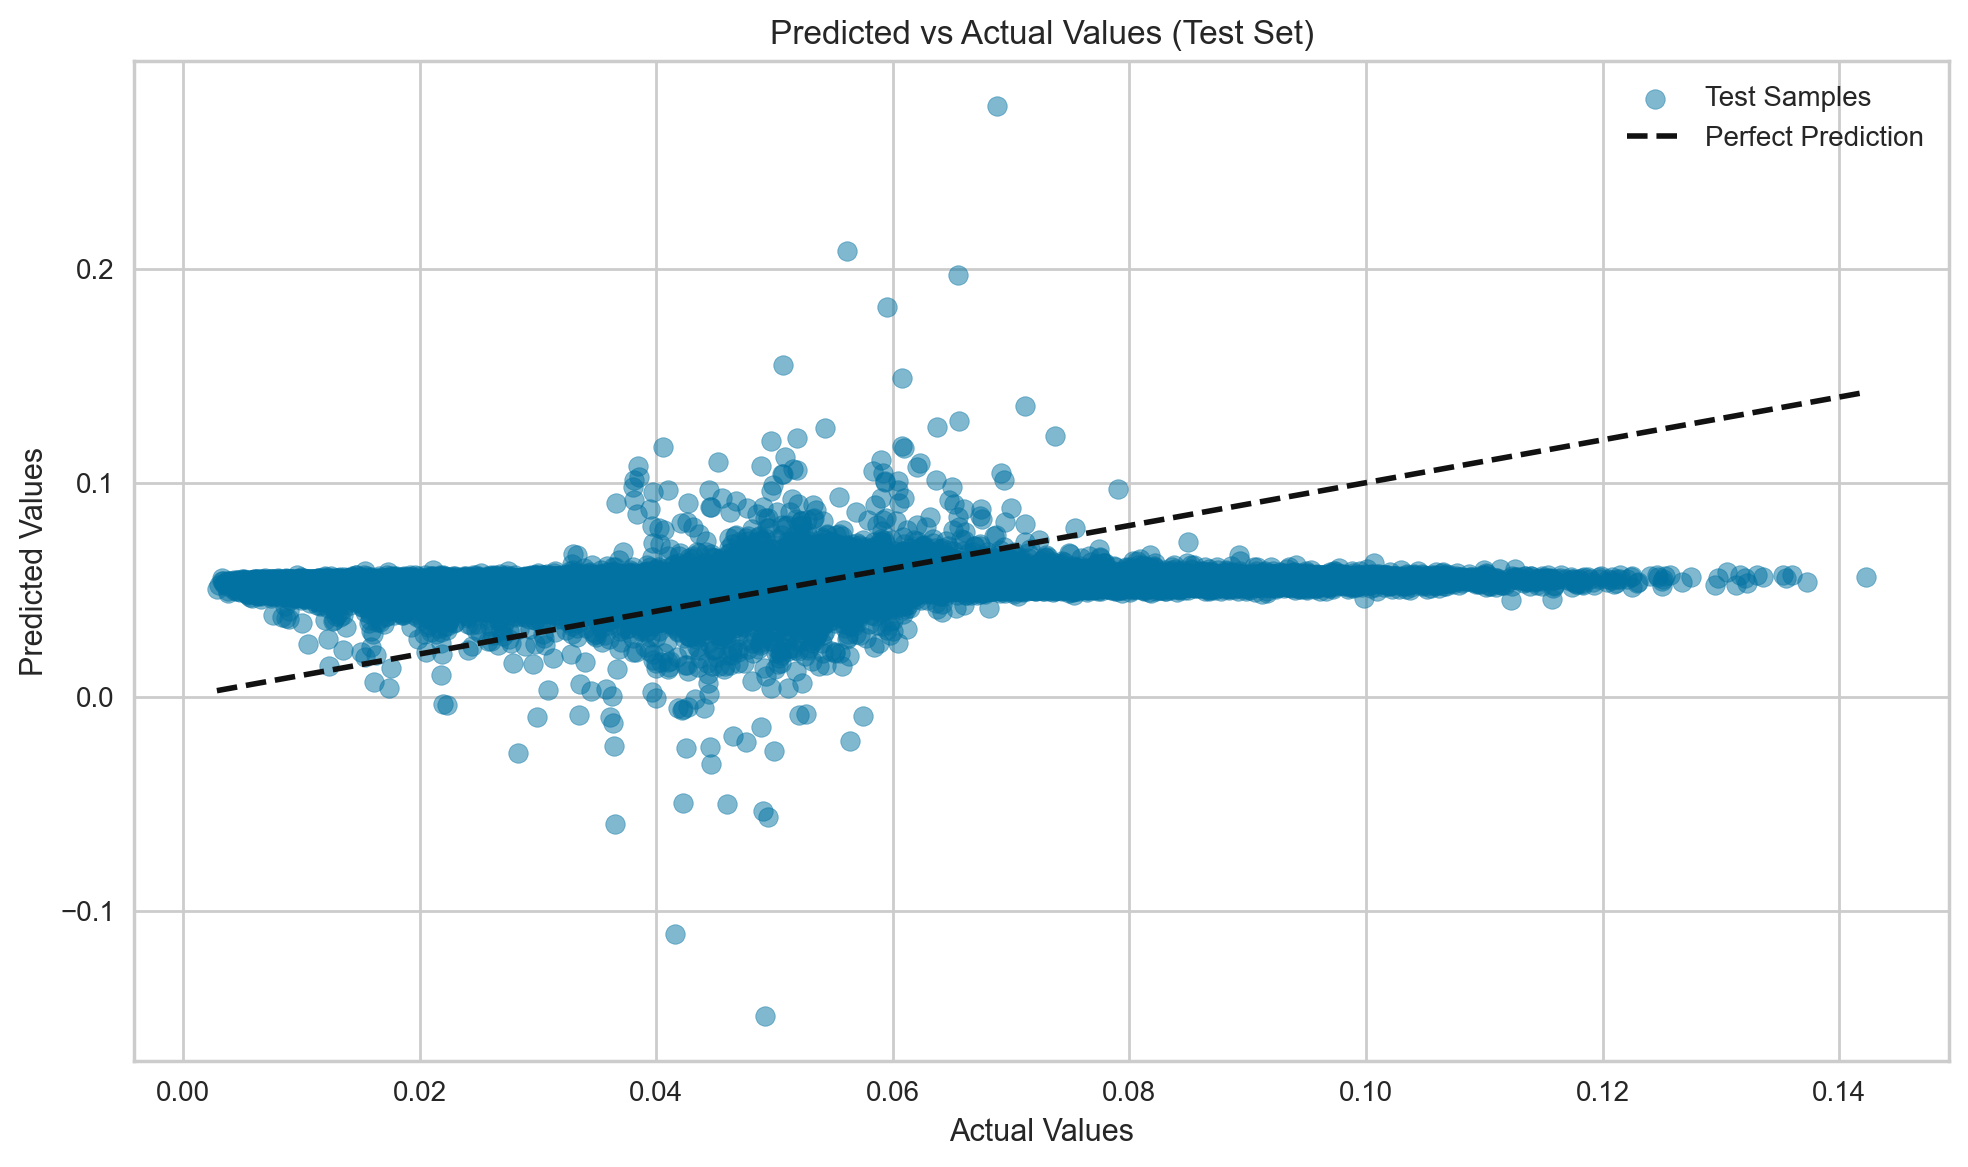

In [ ]:
# Scatter plot of predicted vs actual on test - PCA
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_test_pred_pca, alpha=0.5, label='Test Samples')
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         'k--', lw=2, label='Perfect Prediction')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Predicted vs Actual Values (Test Set)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# Bootstrapped Confidence Intervals
n_bootstraps = 100
bootstrap_scores_pca = []

for _ in range(n_bootstraps):
    # Resample with replacement
    X_bs_pca, y_bs_pca = resample(X_test_pca, y_test)
    y_bs_pred_pca = best_elastic_net_model_pca.predict(X_bs_pca)
    bootstrap_scores_pca.append(r2_score(y_bs_pca, y_bs_pred_pca))

# Calculate confidence interval
ci_lower_pca = np.percentile(bootstrap_scores_pca, 2.5)
ci_upper_pca = np.percentile(bootstrap_scores_pca, 97.5)

print(f"\nBootstrap Confidence Intervals:")
print(f"Original R²: {test_r2_pca:.3f}")
print(f"95% CI: [{ci_lower_pca:.3f}, {ci_upper_pca:.3f}]")


Bootstrap Confidence Intervals:
Original R²: 0.074
95% CI: [0.071, 0.077]


In [ ]:
# Transform back to original feature space (approximate)
original_feature_importance_pca = np.abs(nPCA.components_.T @ best_coefs_pca)

# Create a DataFrame for importance of top features
importance_df_pca = pd.DataFrame({
    'Feature': clustering_train.columns,
    'Importance': original_feature_importance_pca,
    'abs_coef': np.abs(original_feature_importance_pca)
}).sort_values('abs_coef', ascending=False)

print("Top influential original features:")
print(importance_df_pca.head(5))

Top influential original features:
       Feature  Importance  abs_coef
307  ECYHTAAVG    0.000241  0.000241
244  ECYPTAAVG    0.000239  0.000239
360  ECYMTNAVG    0.000229  0.000229
328  ECYHMAAVG    0.000223  0.000223
265  ECYPMAAVG    0.000221  0.000221


#### Regular variables

In [ ]:
# Grid search for parameters - original covariates
param_distributions = {
    'alpha': np.logspace(-3, 1, 20),
    'l1_ratio': np.linspace(0, 1, 11)
}
elastic_net = ElasticNet(fit_intercept=True, random_state=2025)
kf = KFold(n_splits=5, shuffle=True, random_state=2025)
randomized_search = RandomizedSearchCV(
    estimator=elastic_net,
    param_distributions=param_distributions,
    n_iter=50,
    scoring='neg_mean_squared_error',
    cv=kf,
    n_jobs=-1,
    random_state=2025
)

np.random.seed(2025)  # For reproducibility
random_indices = np.random.choice(len(X_scaled), size=10000, replace=False)
X_scaled_sample = X_scaled[random_indices]  # Sample for speed
y_sample = y[random_indices]  # Sample for speed

# Fit on non-PCA data
randomized_search.fit(X_scaled_sample, y_sample)

RandomizedSearchCV(cv=KFold(n_splits=5, random_state=2025, shuffle=True),
                   estimator=ElasticNet(random_state=2025), n_iter=50,
                   n_jobs=-1,
                   param_distributions={'alpha': array([1.00000000e-03, 1.62377674e-03, 2.63665090e-03, 4.28133240e-03,
       6.95192796e-03, 1.12883789e-02, 1.83298071e-02, 2.97635144e-02,
       4.83293024e-02, 7.84759970e-02, 1.27427499e-01, 2.06913808e-01,
       3.35981829e-01, 5.45559478e-01, 8.85866790e-01, 1.43844989e+00,
       2.33572147e+00, 3.79269019e+00, 6.15848211e+00, 1.00000000e+01]),
                                        'l1_ratio': array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])},
                   random_state=2025, scoring='neg_mean_squared_error')

In [ ]:
# Best model
best_alpha = randomized_search.best_params_['alpha']
best_l1_ratio = randomized_search.best_params_['l1_ratio']
print(f"Best alpha: {randomized_search.best_params_['alpha']}")
print(f"Best l1_ratio: {randomized_search.best_params_['l1_ratio']}")

# Note: This is a different model from the PCA one
best_elastic_net_model = ElasticNet(fit_intercept=True, random_state=2025, alpha=best_alpha, l1_ratio=best_l1_ratio)
best_elastic_net_model.fit(X_scaled, y)

Best alpha: 0.001
Best l1_ratio: 0.4


ElasticNet(alpha=np.float64(0.001), l1_ratio=np.float64(0.4), random_state=2025)

In [ ]:
# test data - non-PCA covariates

# np.random.seed(2025)  # For reproducibility
# random_indices = np.random.choice(len(X_test_scaled), size=10000, replace=False)
# X_test_scaled_sample = X_test_scaled[random_indices]  # Sample for speed
# y_test_sample = y_test[random_indices]  # Sample for speed

# predicted values
y_test_pred = best_elastic_net_model.predict(X_test_scaled)

# mse and r-squared
test_mse = mean_squared_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

print(f"\nTest set performance:")
print(f"Non-PCA MSE: {test_mse:.4f}")
print(f"Non-PCA R²: {test_r2:.4f}")


Test set performance:
Non-PCA MSE: 0.0001
Non-PCA R²: 0.3221


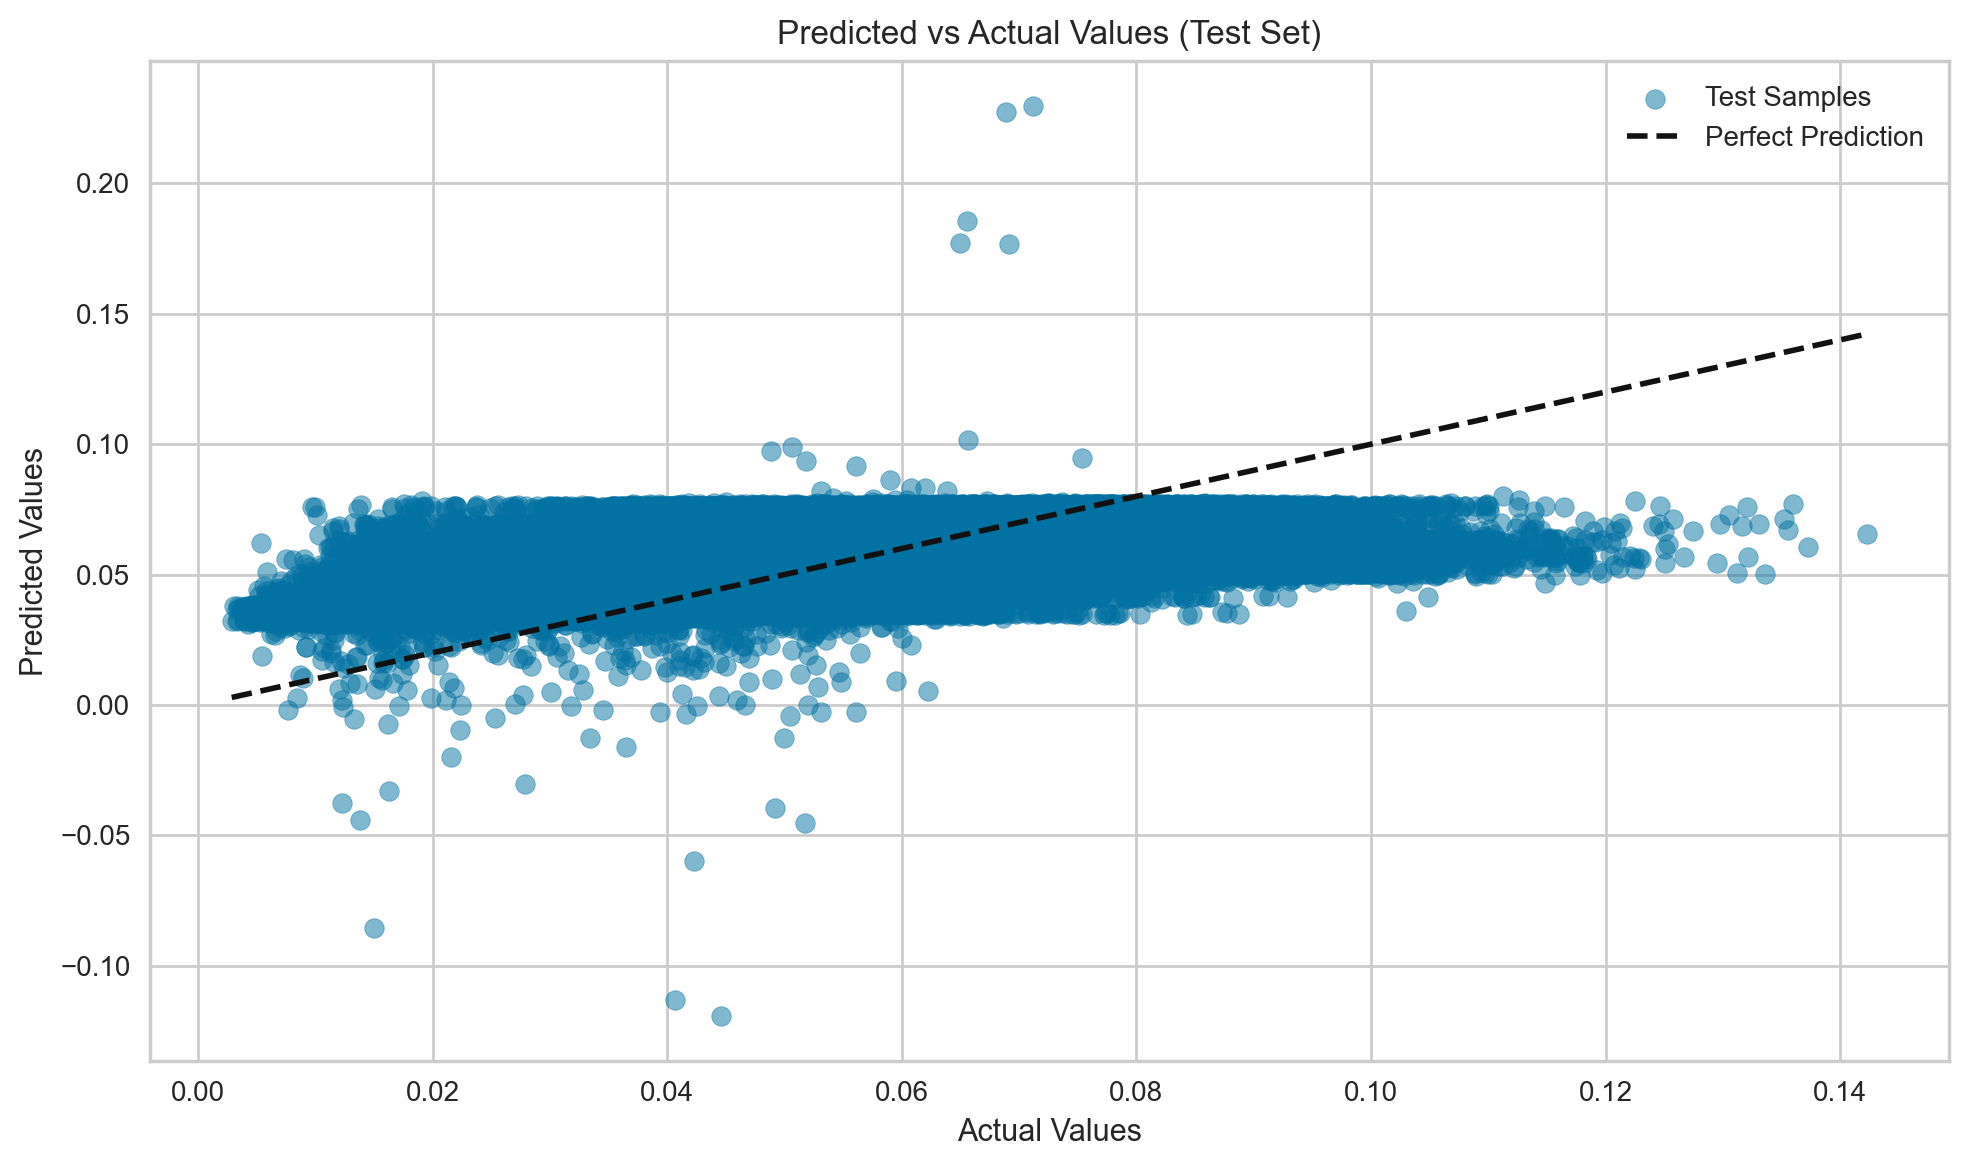

In [ ]:
# Scatter plot of predicted vs actual on test - Non-PCA
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_test_pred, alpha=0.5, label='Test Samples')
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         'k--', lw=2, label='Perfect Prediction')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Predicted vs Actual Values (Test Set)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# Bootstrapped Confidence Intervals - Non-PCA
n_bootstraps = 100  # Reduced from 10000 for speed

bootstrap_scores = Parallel(n_jobs=-1)(
    delayed(compute_bootstrap_r2)(X_test_scaled, y_test, best_elastic_net_model)
    for _ in range(n_bootstraps)
)

# Calculate confidence interval
ci_lower = np.percentile(bootstrap_scores, 2.5)
ci_upper = np.percentile(bootstrap_scores, 97.5)

print(f"\nBootstrap Confidence Intervals:")
print(f"Non-PCA Original R²: {test_r2:.3f}")
print(f"95% CI: [{ci_lower:.3f}, {ci_upper:.3f}]")


Bootstrap Confidence Intervals:
Non-PCA Original R²: 0.322
95% CI: [0.319, 0.326]


In [ ]:
# Create a DataFrame for importance of top features
best_elastic_net_coefs = best_elastic_net_model.coef_
importance_df = pd.DataFrame({
    'Feature': train_data_pd.drop('Proportion_spend', axis=1).columns,
    'Importance': best_elastic_net_coefs,
    'abs_coef': np.abs(best_elastic_net_coefs)
}).sort_values('abs_coef', ascending=False)

print("Top influential original features:")
print(importance_df.head(5))

Top influential original features:
        Feature  Importance  abs_coef
361   ECYMTNMED   -0.006936  0.006936
536  ECYINDPUBL    0.001492  0.001492
360   ECYMTNAVG   -0.001003  0.001003
108     HSCC014   -0.000878  0.000878
198     HSTR052   -0.000821  0.000821


## XGB regression (For PCA covariates and non-PCA covariates)

### PCA covariates

In [ ]:
# XGboost parameter grid
param_grid_xgb = {
    'n_estimators': np.arange(120,140),          # Fewer trees than classification
    'max_depth': np.arange(4,10),                  # Shallower trees often better for regression
    'learning_rate': np.arange(0.034,0.043,0.001),      # Smaller learning rates preferred
}
XGB_regressor = XGBRegressor(
    subsample=0.8,             # Slightly less than 1 for large datasets
    random_state=2025,
    tree_method='hist', # Faster for large datasets
)
rand_search_xgb_pca = RandomizedSearchCV(XGB_regressor, param_grid_xgb, cv=5, scoring='neg_mean_squared_error', n_jobs=-1, n_iter=30, refit=True,verbose=0)

np.random.seed(2025)  # For reproducibility
random_indices = np.random.choice(len(X_pca), size=10000, replace=False)
X_pca_sample = X_pca[random_indices]  # Sample for speed
y_pca_sample = y[random_indices]  # Sample for speed
rand_search_xgb_pca.fit(X_pca_sample, y_pca_sample)

RandomizedSearchCV(cv=5,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, device=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          feature_weights=None, gamma=None,
                                          grow_policy=None,
                                          importance_type=None,
                                          interaction_constraint...
                                          multi_strategy=None,
                                          n_estimators=None, n_jobs=None,
                                          num_parallel_tree=None, ...),
                   n_iter=30, n_jobs=-1,
                   param_distributions={'learning_rate': array([0.034, 0.035, 0.036, 0.037, 0.038, 0.039, 0.04 , 0.041, 0.042]),
                                        'max_depth': array([4, 5, 6, 7, 8, 9]),
                                        'n_estimators': array([120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132,
       133, 134, 135, 136, 137, 138, 139])},
                   scoring='neg_mean_squared_error')

In [ ]:
best_estimators = rand_search_xgb_pca.best_params_['n_estimators']
best_depth = rand_search_xgb_pca.best_params_['max_depth']
best_learning_rate = rand_search_xgb_pca.best_params_['learning_rate']
# best model pca
print(f"\nBest parameters: {rand_search_xgb_pca.best_params_}") # n_estimators = 129, max_depth = 7, learning rate = 0.041
print(f"Best CV MSE: {-rand_search_xgb_pca.best_score_:.4f}")

best_xgb_pca = XGBRegressor(
    n_estimators=best_estimators,
    max_depth=best_depth,
    learning_rate=best_learning_rate,
    subsample=0.8,
    random_state=2025,
    tree_method='hist'
)

best_xgb_pca.fit(X_pca, y)


Best parameters: {'n_estimators': np.int64(131), 'max_depth': np.int64(7), 'learning_rate': np.float64(0.04200000000000001)}
Best CV MSE: 0.0001


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=np.float64(0.04200000000000001), max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=np.int64(7), max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=np.int64(131), n_jobs=None,
             num_parallel_tree=None, ...)

In [ ]:
# test evaluation pca
y_test_pred_pca = best_xgb_pca.predict(X_test_pca)
test_mse_pca = mean_squared_error(y_test, y_test_pred_pca)
test_r2_pca = r2_score(y_test, y_test_pred_pca)
print(f"\nTest Performance:")
print(f"MSE: {test_mse_pca:.4f}")
print(f"R²: {test_r2_pca:.4f}")


Test Performance:
MSE: 0.0001
R²: 0.4066


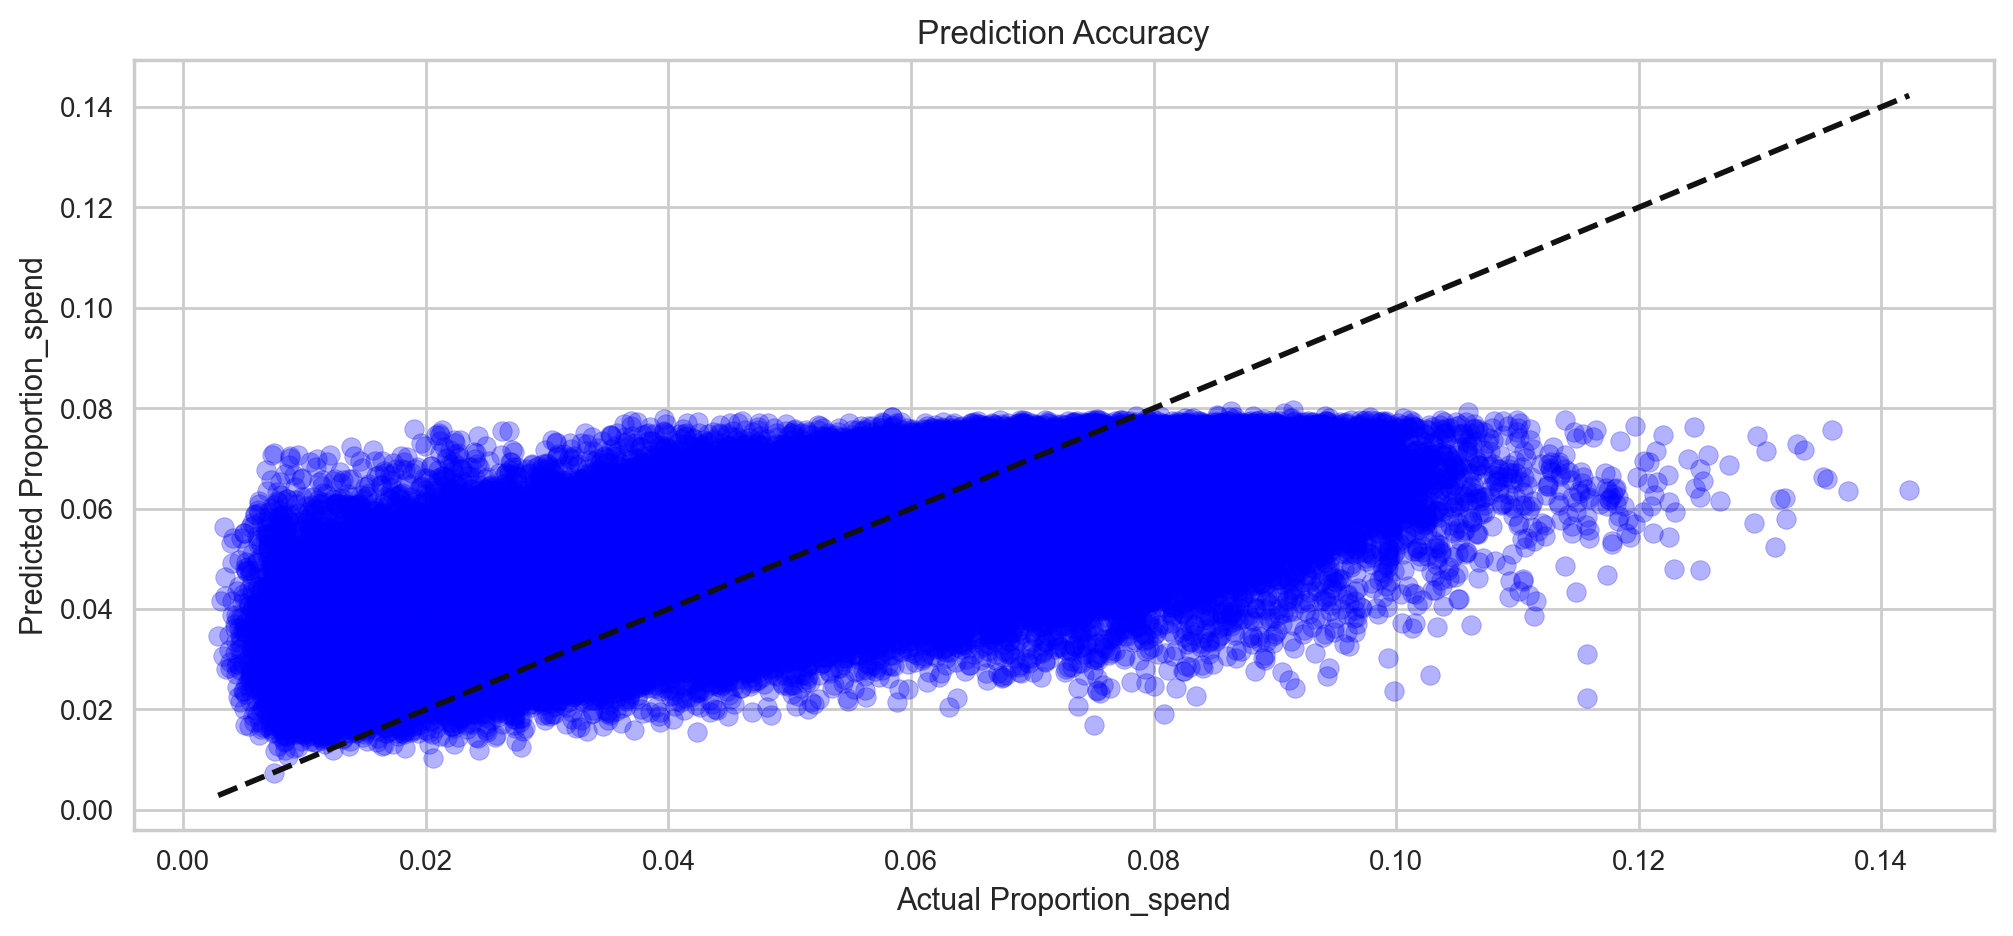

In [ ]:
plt.figure(figsize=(12, 5))

# Predicted vs Actual
plt.scatter(y_test, y_test_pred_pca, alpha=0.3, color='blue')
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         'k--', lw=2)
plt.xlabel('Actual Proportion_spend')
plt.ylabel('Predicted Proportion_spend')
plt.title('Prediction Accuracy')
plt.show()

In [ ]:
# Bootstrap Confidence Interval for xgb
n_bootstraps = 100

bootstrap_scores = Parallel(n_jobs=-1)(
    delayed(compute_bootstrap_r2)(X_test_pca, y_test, best_xgb_pca)
    for _ in range(n_bootstraps)
)

ci_lower = np.percentile(bootstrap_scores, 2.5)
ci_upper = np.percentile(bootstrap_scores, 97.5)

print(f"\nBootstrap Confidence Intervals:")
print(f"R² value: {test_r2_pca:.3f}")
print(f"95% CI: [{ci_lower:.3f}, {ci_upper:.3f}]")


Bootstrap Confidence Intervals:
R² value: 0.407
95% CI: [0.403, 0.410]


In [ ]:
# Transform back to original feature space (approximate)
best_coefs_xgb_pca = rand_search_xgb_pca.best_estimator_.feature_importances_
original_feature_importance_pca = np.abs(nPCA.components_.T @ best_coefs_xgb_pca)

# Create a DataFrame for importance of top features
importance_df_pca = pd.DataFrame({
    'Feature': clustering_train.columns,
    'Importance': original_feature_importance_pca,
    'abs_coef': np.abs(original_feature_importance_pca)
}).sort_values('abs_coef', ascending=False)

print("Top influential original features:")
print(importance_df_pca.head(5))

Top influential original features:
       Feature  Importance  abs_coef
307  ECYHTAAVG    0.053696  0.053696
244  ECYPTAAVG    0.052889  0.052889
328  ECYHMAAVG    0.049779  0.049779
265  ECYPMAAVG    0.049156  0.049156
360  ECYMTNAVG    0.048197  0.048197


### For normal covariates

In [ ]:
param_grid_xgb = {
    'n_estimators': np.arange(115,125),          # Fewer trees than classification
    'max_depth': np.arange(8,15),                  # Shallower trees often better for regression
    'learning_rate': np.arange(0.036,0.04,0.001),      # Smaller learning rates preferred
}

XGB_regressor = XGBRegressor(
    subsample=0.8,             # Slightly less than 1 for large datasets
    random_state=2025,
    tree_method='hist', # Faster for large datasets
)
grid_search_xgb = RandomizedSearchCV(XGB_regressor, param_grid_xgb, cv=5, scoring='neg_mean_squared_error', n_jobs=-1, n_iter=30, refit=True,verbose=0)

np.random.seed(2025)  # For reproducibility
random_indices = np.random.choice(len(X_scaled), size=1000, replace=False)
X_scaled_sample = X_scaled[random_indices]  # Sample for speed
y_sample = y[random_indices]  # Sample for speed
grid_search_xgb.fit(X_scaled_sample, y_sample)

RandomizedSearchCV(cv=5,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, device=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          feature_weights=None, gamma=None,
                                          grow_policy=None,
                                          importance_type=None,
                                          interaction_constraint...
                                          min_child_weight=None, missing=nan,
                                          monotone_constraints=None,
                                          multi_strategy=None,
                                          n_estimators=None, n_jobs=None,
                                          num_parallel_tree=None, ...),
                   n_iter=30, n_jobs=-1,
                   param_distributions={'learning_rate': array([0.036, 0.037, 0.038, 0.039, 0.04 ]),
                                        'max_depth': array([ 8,  9, 10, 11, 12, 13, 14]),
                                        'n_estimators': array([115, 116, 117, 118, 119, 120, 121, 122, 123, 124])},
                   scoring='neg_mean_squared_error')

In [ ]:
# best model - non-PCA
best_estimators = grid_search_xgb.best_params_['n_estimators']
best_depth = grid_search_xgb.best_params_['max_depth']
best_learning_rate = grid_search_xgb.best_params_['learning_rate']

# best model pca
print(f"\nBest parameters: {grid_search_xgb.best_params_}") # n_estimators = 129, max_depth = 7, learning rate = 0.041
print(f"Best CV MSE: {-grid_search_xgb.best_score_:.4f}")

best_xgb = XGBRegressor(
    n_estimators=best_estimators,
    max_depth=best_depth,
    learning_rate=best_learning_rate,
    subsample=0.8,
    random_state=2025,
    tree_method='hist'
)

best_xgb.fit(X_scaled, y)


Best parameters: {'n_estimators': np.int64(124), 'max_depth': np.int64(8), 'learning_rate': np.float64(0.038)}
Best CV MSE: 0.0001


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=np.float64(0.038), max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=np.int64(8), max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=np.int64(124), n_jobs=None,
             num_parallel_tree=None, ...)

In [ ]:
np.random.seed(2025)  # For reproducibility
random_indices = np.random.choice(len(X_test_scaled), size=1000, replace=False)
X_test_scaled_sample = X_test_scaled[random_indices]  # Sample for speed
y_test_sample = y_test[random_indices]  # Sample for speed

# test evaluation
y_test_pred = best_xgb.predict(X_test_scaled)
test_mse = mean_squared_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)
print(f"\nTest Performance:")
print(f"MSE: {test_mse:.4f}")
print(f"R²: {test_r2:.4f}")


Test Performance:
MSE: 0.0001
R²: 0.7721


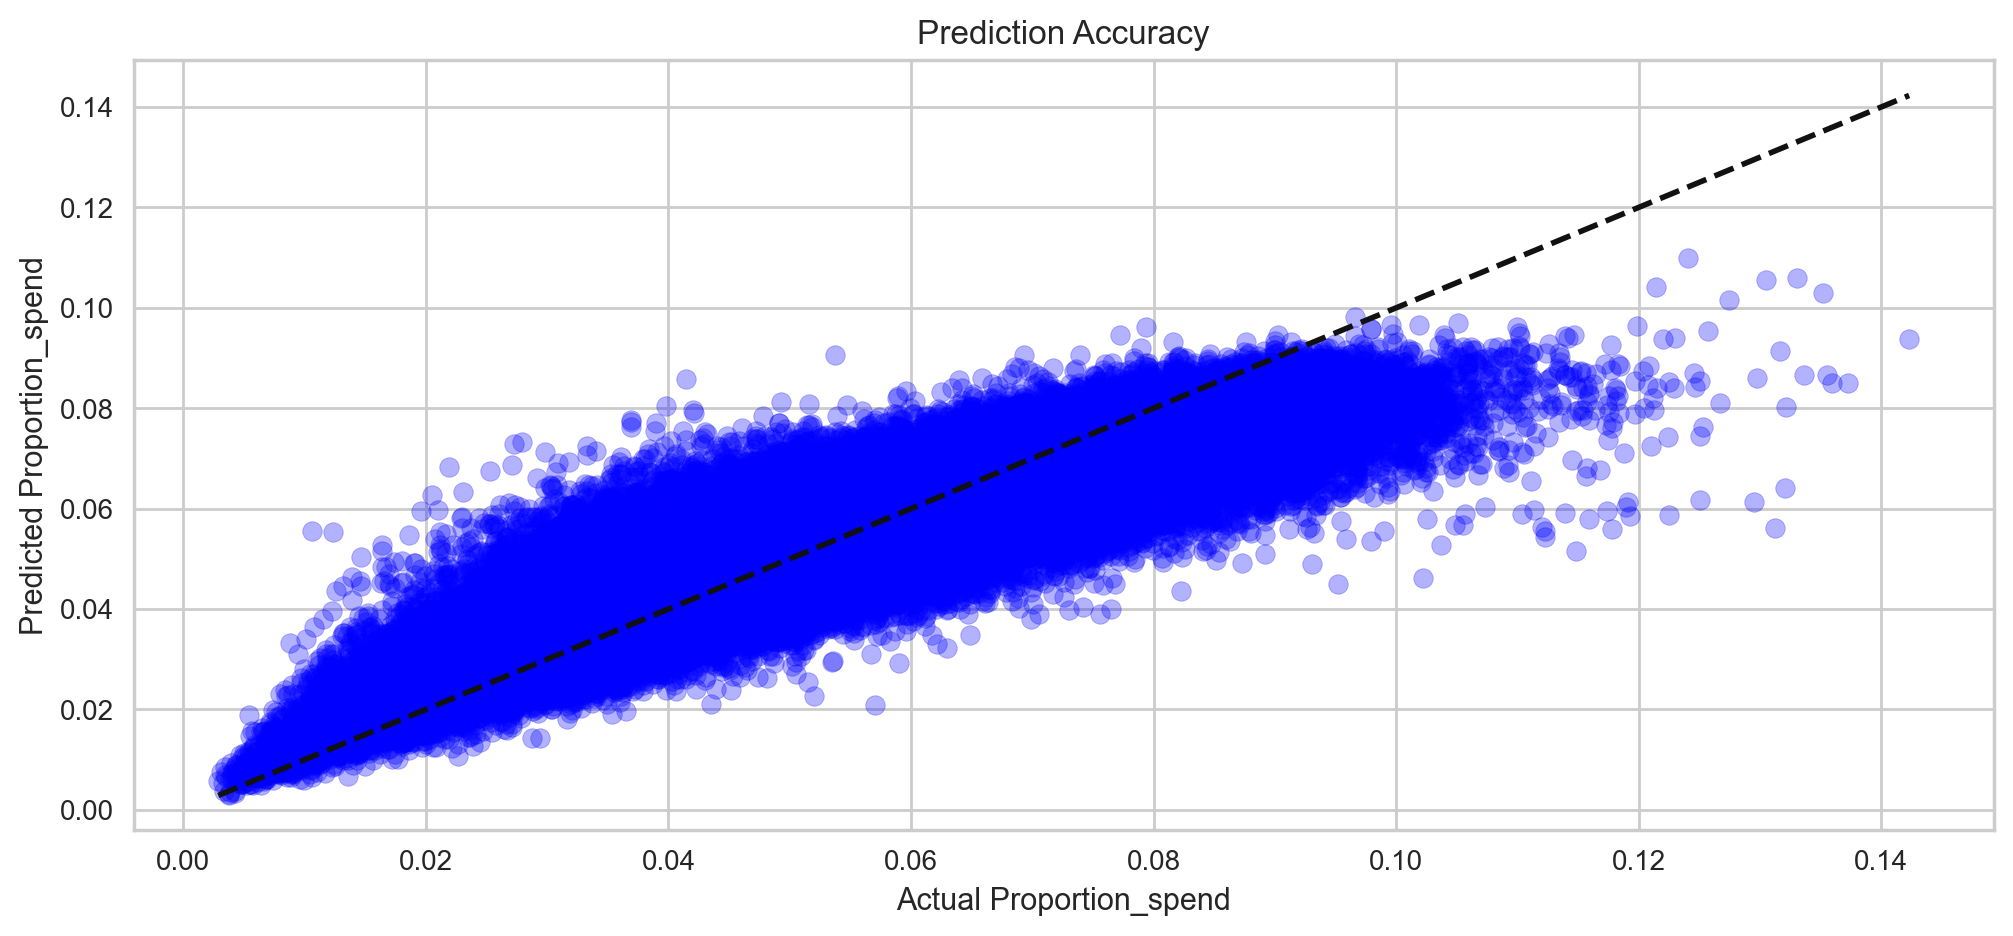

In [ ]:
plt.figure(figsize=(12, 5))

# Predicted vs Actual
plt.scatter(y_test, y_test_pred, alpha=0.3, color='blue')
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         'k--', lw=2)
plt.xlabel('Actual Proportion_spend')
plt.ylabel('Predicted Proportion_spend')
plt.title('Prediction Accuracy')
plt.show()

In [ ]:
# Bootstrap Confidence Interval for xgb
n_bootstraps = 100

bootstrap_scores = Parallel(n_jobs=-1)(
    delayed(compute_bootstrap_r2)(X_test_scaled, y_test, best_xgb)
    for _ in range(n_bootstraps)
)

ci_lower = np.percentile(bootstrap_scores, 2.5)
ci_upper = np.percentile(bootstrap_scores, 97.5)

print(f"\nBootstrap Confidence Intervals:")
print(f"R² value: {test_r2:.3f}")
print(f"95% CI: [{ci_lower:.3f}, {ci_upper:.3f}]")


Bootstrap Confidence Intervals:
R² value: 0.772
95% CI: [0.770, 0.774]


In [ ]:
# Create a DataFrame for importance of top features
best_xgb_coefs = best_xgb.feature_importances_
importance_df = pd.DataFrame({
    'Feature': train_data_pd.drop('Proportion_spend', axis=1).columns,
    'Importance': best_xgb_coefs,
    'abs_coef': np.abs(best_xgb_coefs)
}).sort_values('abs_coef', ascending=False)

print("Top influential original features:")
print(importance_df.head(5))

Top influential original features:
        Feature  Importance  abs_coef
361   ECYMTNMED    0.115073  0.115073
360   ECYMTNAVG    0.092727  0.092727
47      HSSH033    0.035696  0.035696
636  ECYHOMFREN    0.031243  0.031243
482  ECYEDACOLL    0.018329  0.018329


## Comparing elastic net to xgboost

In [ ]:
X_columns = train_data_pd.drop('Proportion_spend', axis=1).columns
X_pca_columns = clustering_train.columns

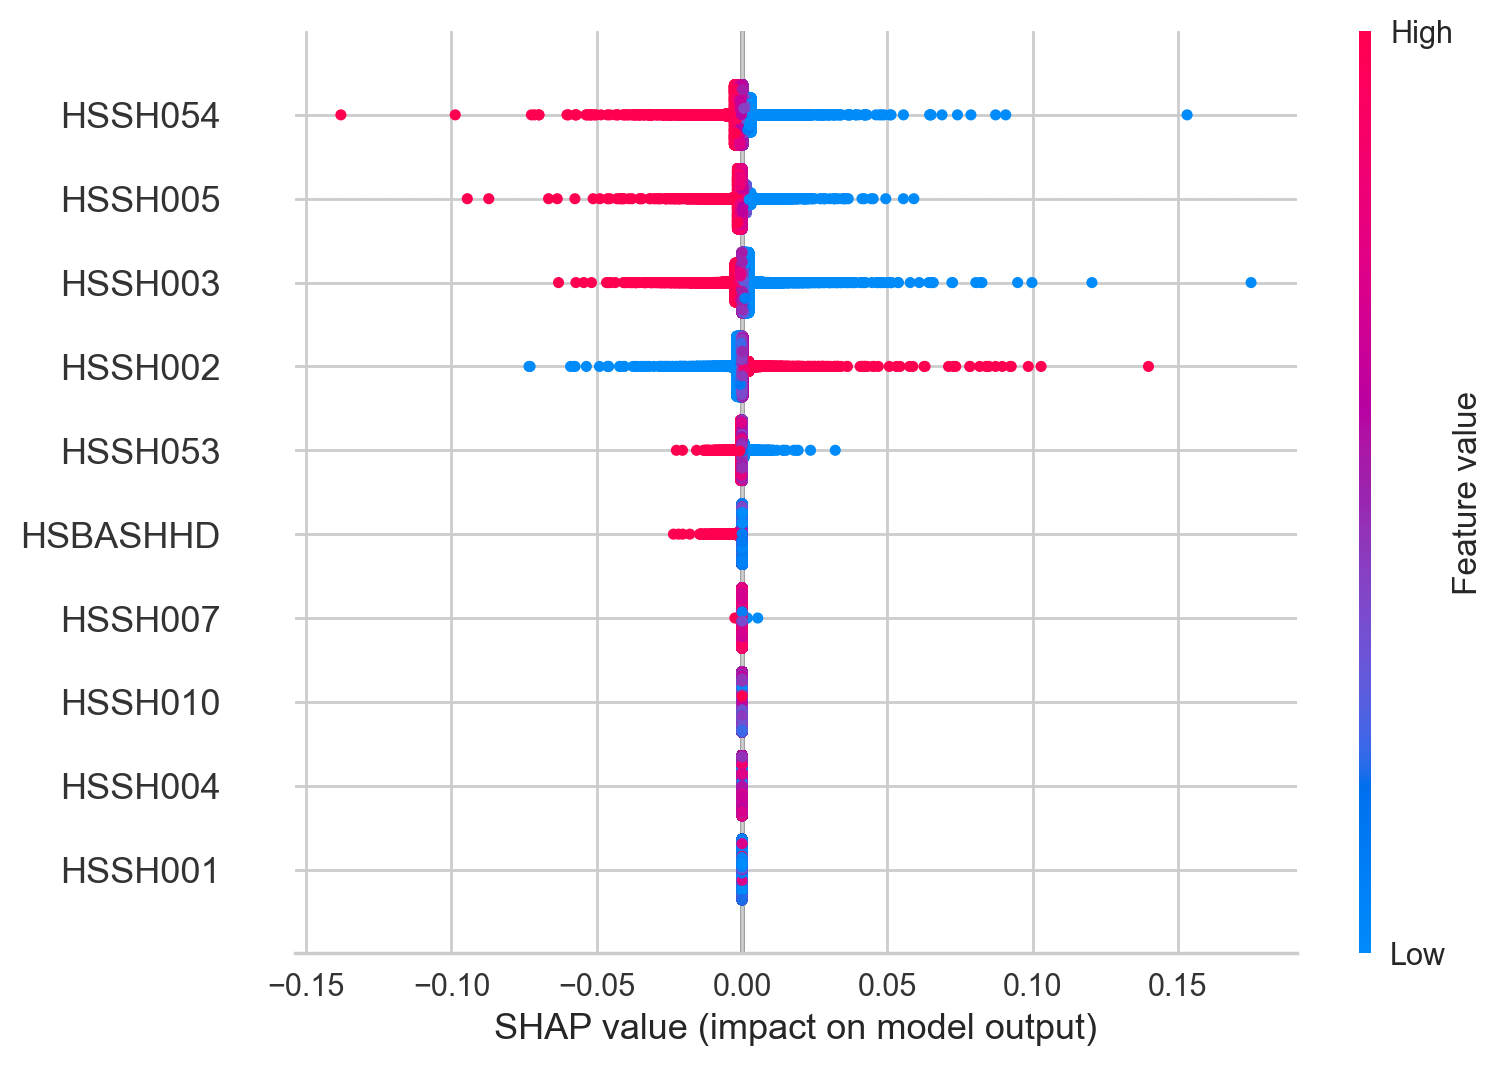

In [ ]:
# Shap values for ElasticNet - PCA
explainer_elastic_net_pca = shap.LinearExplainer(best_elastic_net_model_pca, masker=shap.maskers.Independent(X_pca, max_samples=1000), feature_names=X_columns)
shap_values_elastic_net_pca = explainer_elastic_net_pca.shap_values(X_test_pca)
shap.summary_plot(shap_values_elastic_net_pca, X_test_pca, rng=2025, feature_names=X_columns, show=True)

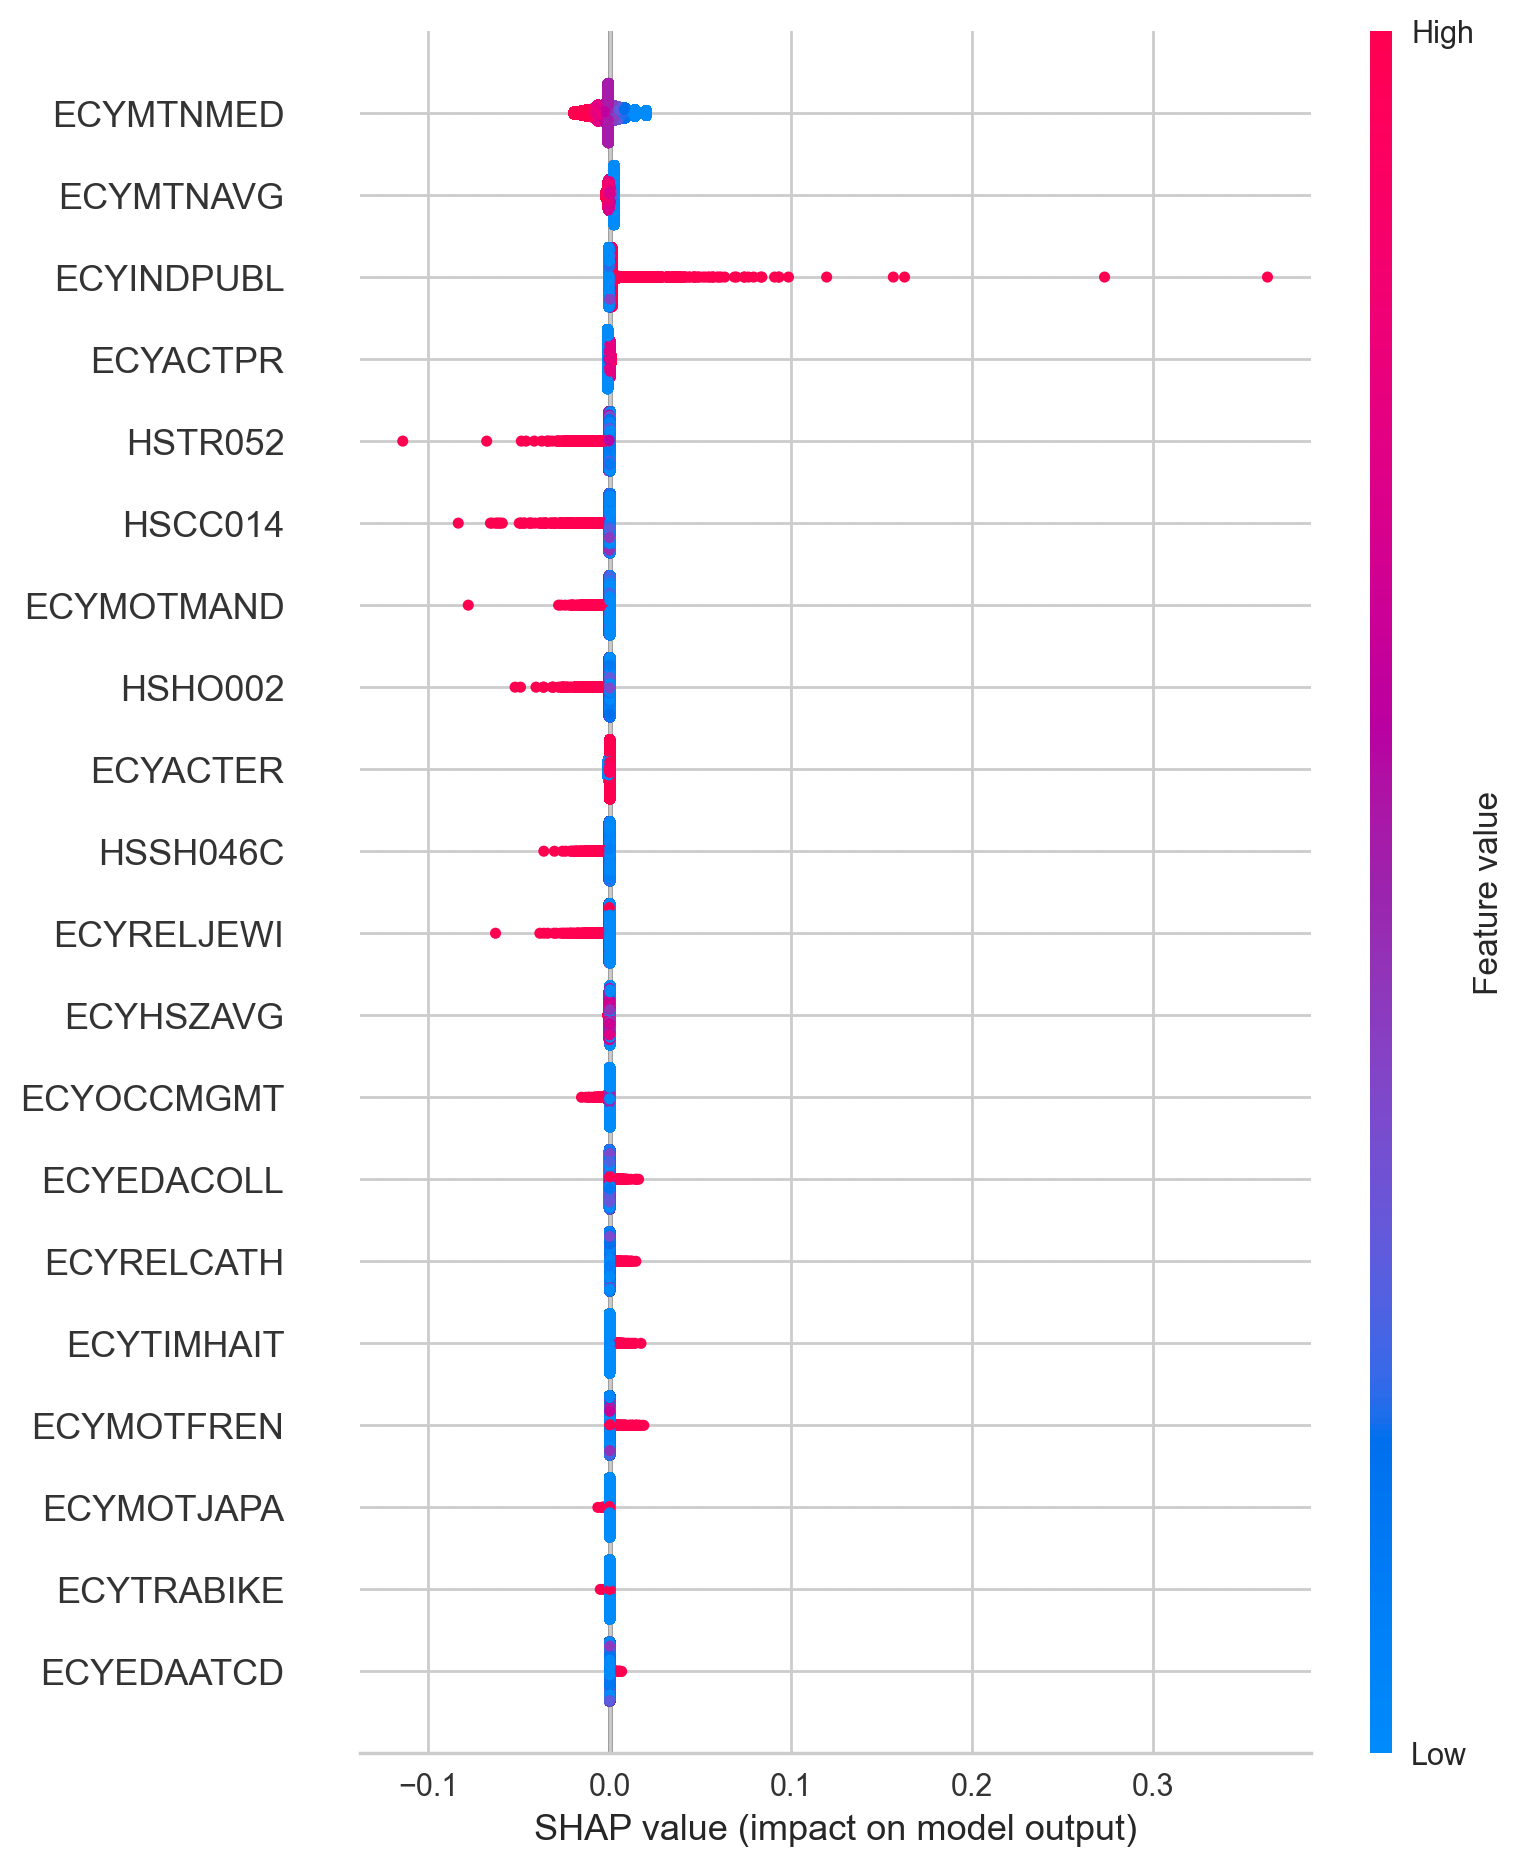

In [ ]:
# Shap values for ElasticNet - Non-PCA
explainer_elastic_net = shap.LinearExplainer(best_elastic_net_model, masker=shap.maskers.Independent(X_scaled, max_samples=1000), feature_names=X_columns)
shap_values_elastic_net = explainer_elastic_net.shap_values(X_test_scaled)
shap.summary_plot(shap_values_elastic_net, X_test_scaled, rng=2025, feature_names=X_columns, show=True)

100%|===================| 260589/260691 [33:51<00:00]        

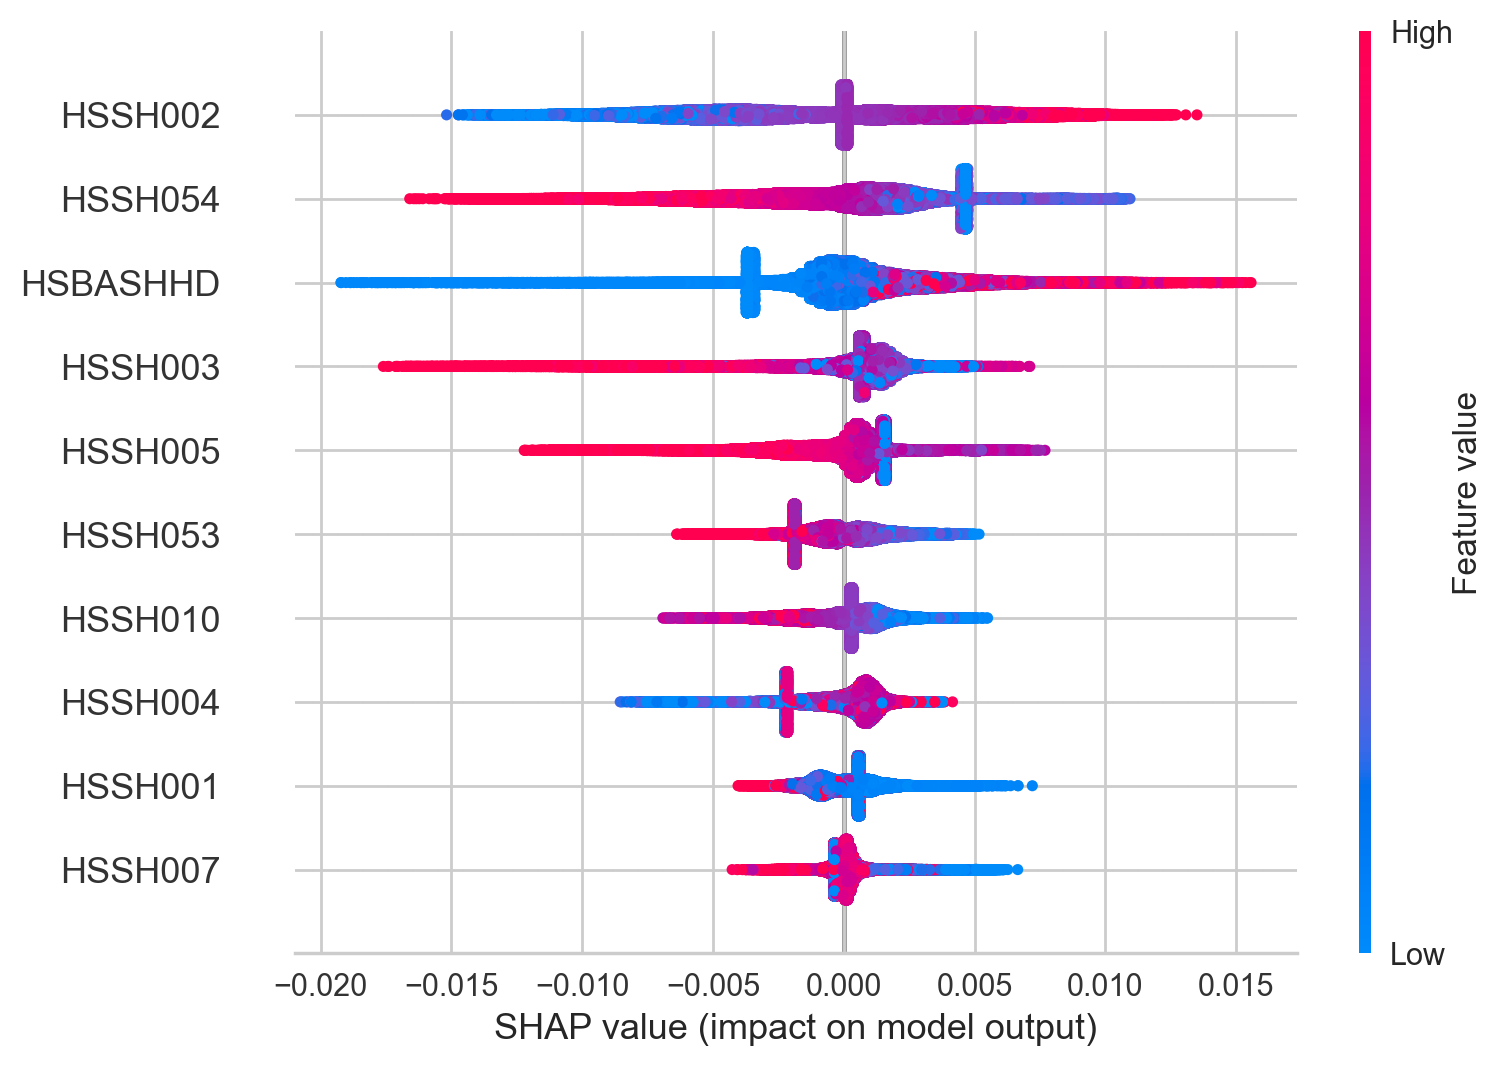

In [ ]:
# SHAP values for XGBRegressor - PCA
explainer_xgb_pca = shap.TreeExplainer(best_xgb_pca, data=shap.sample(X_pca, 1000), feature_names=X_pca_columns)
shap_values_xgb_pca = explainer_xgb_pca.shap_values(X_test_pca, check_additivity=False)
shap.summary_plot(shap_values_xgb_pca, X_test_pca, rng=2025, feature_names=X_pca_columns, show=True)

100%|===================| 260688/260691 [66:45<00:00]        

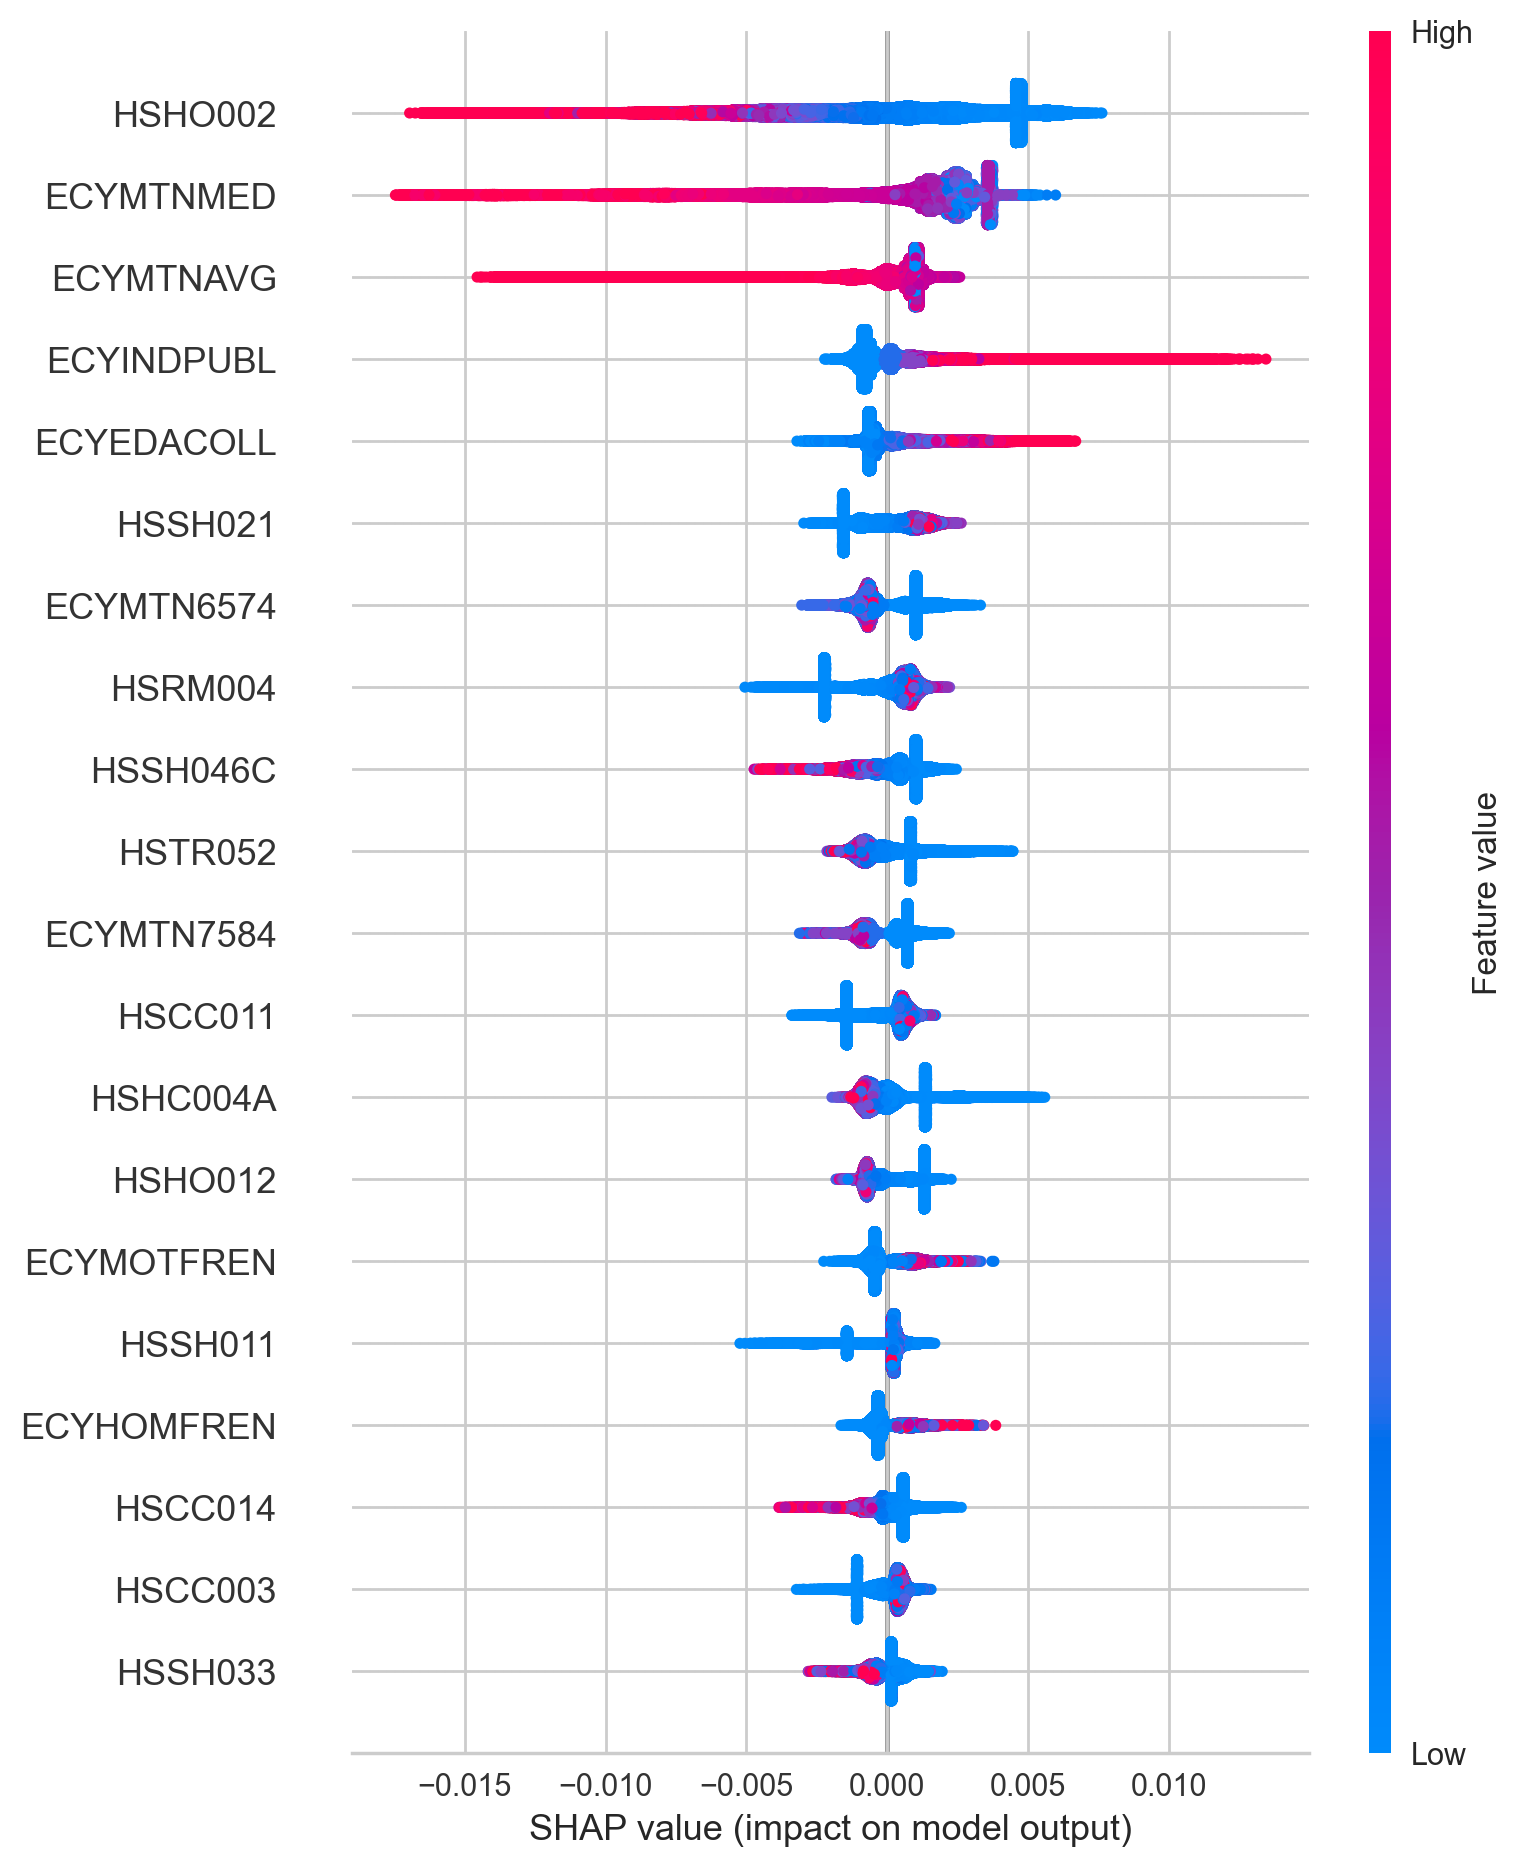

In [ ]:
# SHAP values for XGBRegressor - Non-PCA
explainer_xgb = shap.TreeExplainer(best_xgb, data=shap.sample(X_scaled,1000), feature_names=X_columns)
shap_values_xgb = explainer_xgb.shap_values(X_test_scaled, check_additivity=False)
shap.summary_plot(shap_values_xgb, X_test_scaled, rng=2025, feature_names=X_columns, show=True)